# Introduction

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np

# Stats
import statsmodels.tsa.stattools # for ADF test and coint function
import statsmodels.api # for OLS

# from scipy.stats import norm  # to fit normal dist to data
# import matplotlib.mlab as mlab  # to generate pdfs

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [206]:
%run analysis.py

This report summarises and demonstrates some of the techniques used at arriving at trading strategies using the concepts of _stationarity_ and _cointegration_. In particular, the focus is on energy commodities.

* Section 1 provides details for the datasets used throughout the report
* Section 2 introduces the concept of Stationarity in time series, which  is the key property exploited by cointegration techniques and mean-reverting strategies
* Section 3 goes in detail about Cointegration and how to test for it, as well as assesing its quality
* Section 4 is then dedicated to the application of these concepts to trading strategies and assesing their performance in terms of profit and loss
* Finally the Appendix summarises some of the mathematical methods involved such as Multivariate Regression models (VAR(p), ECM, Augmented Dickey-Fuller Test and Ornstein–Uhlenbeck processes

# Datasets

## Simulated Data

Unless otherwise stated, stochastic processes are simulated with Monte Carlo (MC) where random samples are drawn from the normal distribution.

## Real Data

* For simplicity, only two finacial series are used to demonstrate the concepts. As the focus is on energy commodities, Brent crude and a byproduct (Low Sulphur Gasoil) were selected since they were assumed to be good candidates for cointegration given their deep economic link
* The [Brent](https://www.theice.com/products/219/Brent-Crude-Futures) and [Gasoil](https://www.theice.com/products/34361119/Low-Sulphur-Gasoil-Futures) Futures prices traded in the Intercontinental Exchange (ICE) were taken from  [Quandl's Steven Continuous Series](https://www.quandl.com/data/SCF/documentation/about) using the 'Roll on Last Trading Day with No Price Adjustment' version and the 'Settle' field
* The two series were joined to produce a single dataset consisting of daily settlement prices for Brent and Gasoil
* The dataset spans 1.5 'trading years'. The period selected was Jan-2014 to Dec-2014  for the in-sample testing and Jan-2015 to Jun-2015 for the out-of-sample testing. This was because several sources recommend to use one year of historic data to estimate the cointegration parameters and trade the estimates for a 6-month period, given that the parameters might change over time or the relationship cease to exist
* Dates with missing values after joining the two series were dropped
* Since Gasoil is traded in metric tons and Brent in barrels, the gasoil series was divided by 7.45, which is the [ICE conversion factor](https://www.theice.com/publicdocs/futures/ICE_Gas_Oil_Crack.pdf)

The figure below shows the resulting dataset (spanning both in-sample and out-of-sample periods), where the two series indeed seem to be closely related, having parallel up and down trends.

In [391]:
temp = pd.read_csv("data/df_brent_gasoil.csv", index_col=0, parse_dates=True, dayfirst=True)
df = temp[datetime(2014, 1, 1):datetime(2015, 6, 30)]
df_is = df[datetime(2014, 1, 1):datetime(2014, 12, 31)]  # in-sample dataset
df_os = df[datetime(2015, 1, 1):datetime(2015, 12, 31)]  # out-of-sample dataset
print df.head()
print df.tail()

             brent      gasoil
Date                          
2014-01-02  107.78  123.959732
2014-01-03  106.89  122.181208
2014-01-06  106.73  122.181208
2014-01-07  107.35  122.214765
2014-01-08  107.15  122.449664
            brent     gasoil
Date                        
2015-06-24  63.49  77.986577
2015-06-25  63.20  76.543624
2015-06-26  63.26  77.046980
2015-06-29  62.01  75.771812
2015-06-30  63.59  77.013423


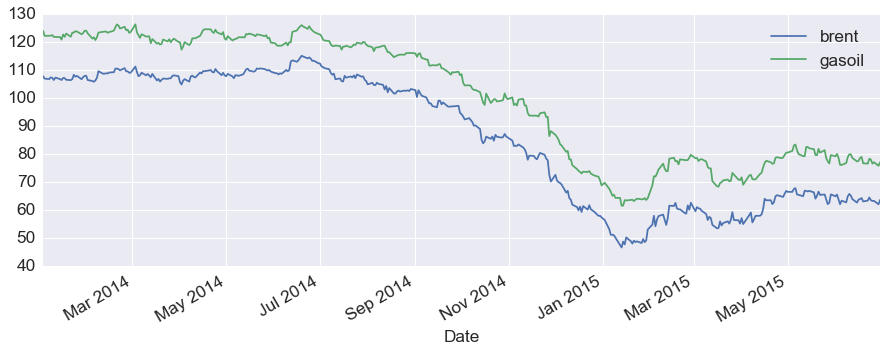

In [392]:
_ = df.plot()

# Stationarity and Mean-Reversion

Before cointegration is introduced, it is important to understand the concept of stationarity. A time series is stationary when the parameters of its generating process do not change over time. In particular, its long-run mean and variance stay constant. This property is fundamental when applying linear regression and forecasting models.

Often, processes with a drift or trend, like stock prices, are non-stationary but can be transformed to become stationary. For example, by differencing prices we get returns, which are in general stationary.

The figure below shows how a simulated random walk with drift $Y_t = \alpha + Y_{t-1} + \epsilon_t$ can be made stationary by differencing $Y_t - Y_{t-1} = \alpha + \epsilon_t$

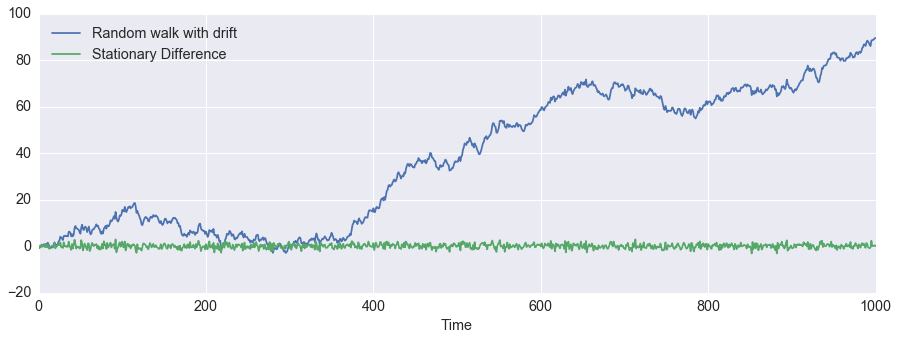

In [51]:
np.random.seed(1000)  # set the seed
M = 1000  # no. of time steps
Y_t = np.zeros((M + 1))
Y_t[0] = 0.0  # initial value
a = 0.1  # drift

for i in xrange(1, M + 1, 1):
    Y_t[i] = a + Y_t[i-1] + np.random.normal(0, 1)

# Y_t = pd.Series(index=range(M), data=Y_t)
Y_t = pd.Series(Y_t, name='Y_t')
_ = Y_t.plot()
_ = Y_t.diff().plot()
# _ = plt.ylabel('Series Value')
_ = plt.xlabel('Time')
_ = plt.legend(['Random walk with drift', 'Stationary Difference'], loc='upper left')

## Mean-Reversion

A stationary series is mean-reverting if over time it drifts towards its long-term mean (the historical equilibrium level). A popular model in this category is the Ornstein–Uhlenbeck (OU) process:

$$
dY_t = \theta(\mu - Y_t)dt + \sigma dW_t
$$

where $\theta$ is the speed of reversion, $\mu$ is the equilibrium level, $\sigma$ the variance and $W_t$ a Wiener Process (Brownian Motion). In a discrete setting this states that the further away the process is from the mean, the greater the 'pull back' to it is. This is in contrast to the random walk above, which has no "memory" of where it has been at each particular instance of time. 

The figure below shows three OU processes with the same mean $\mu=10$ but   different mean-reversion speeds. Indeed it can be noted the highest speed reverts to the mean first. The differences $dY_t$ are plotted below and these appear to become stationary significantly faster than the process itself, almost insensitive to the speed $\theta$.

Therefore, if we are able to transform a time series to be stationary and mean-reverting, we can design trading strategies using these properties which are more independent of market effects. In a later section we shall see how the OU parameters can be used to design exit/entry thresholds and also assess the 'quality' of mean-reversion.

In [52]:
import math
from math import exp, sqrt, log

# MC params
np.random.seed(2000)  # set the seed
dt = 1  # time step
M = 1000  # no. of time steps

# Model params:
mu = 10
sigma = 0.3

Y_t1 = np.zeros((M + 1))
Y_t2 = np.zeros((M + 1))
Y_t3 = np.zeros((M + 1))

Y_t1[0] = -50.0
Y_t2[0] = 50.0
Y_t3[0] = 0.0

theta1 = 0.003
theta2 = 0.01
theta3 = 0.1

for i in xrange(1, M + 1, 1):
    Y_t1[i] = Y_t1[i-1] + theta1 * (mu - Y_t1[i-1]) * dt + sigma * math.sqrt(dt) * np.random.normal(0, 1)
    Y_t2[i] = Y_t2[i-1] + theta2 * (mu - Y_t2[i-1]) * dt + sigma * math.sqrt(dt) * np.random.normal(0, 1)
    Y_t3[i] = Y_t3[i-1] + theta3 * (mu - Y_t3[i-1]) * dt + sigma * math.sqrt(dt) * np.random.normal(0, 1)

# Y_t = pd.Series(index=range(M), data=Y_t)
Y_t1 = pd.Series(Y_t1, name='Y_t1')
Y_t2 = pd.Series(Y_t2, name='Y_t2')
Y_t3 = pd.Series(Y_t3, name='Y_t3')

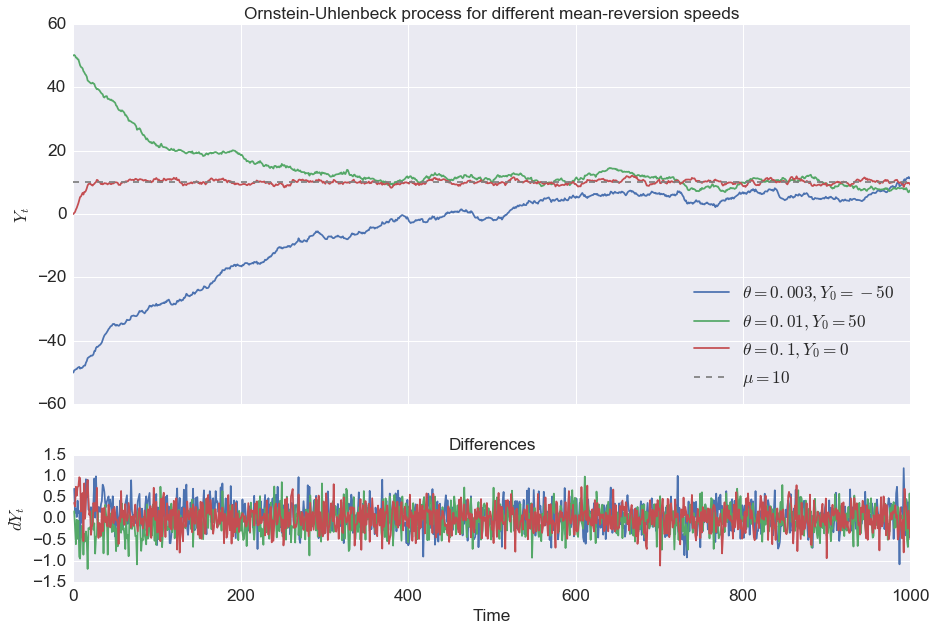

In [393]:
from matplotlib import gridspec

plt.figure(1, figsize=(15, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
ax = plt.subplot(gs[0])
# plt.subplot(211)

# f, (a0, a1) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[2, 1]})
# a0.plot(Y_t1)
# a0.plot(Y_t2)
# a0.plot(Y_t3)
# a0.axhline(mu, color='grey', linestyle='--') 
_ = Y_t1.plot()
_ = Y_t2.plot()
_ = Y_t3.plot()
_ = plt.axhline(mu, color='grey', linestyle='--') 

# _ = plt.ylabel('Series Value')
plt.title('Ornstein-Uhlenbeck process for different mean-reversion speeds')
plt.ylabel('$Y_t$')
plt.legend([r'$\theta={0}, Y_0={1:0.0f}$'.format(theta1, Y_t1[0]), 
            r'$\theta={0}, Y_0={1:0.0f}$'.format(theta2, Y_t2[0]),
            r'$\theta={0}, Y_0={1:0.0f}$'.format(theta3, Y_t3[0]),
            r'$\mu={0}$'.format(mu)],
           loc='lower right')

# # plt.subplot(212)
plt.subplot(gs[1], sharex=ax)
plt.title('Differences')
Y_t1.diff().plot()
Y_t2.diff().plot()
Y_t3.diff().plot()
plt.ylabel('$dY_t$')
plt.xlabel('Time')

## Tests

We require a more robust method to confirm statistically whether a series is stationary. Several tests exist, such as the **Augmente Dickey-Fuller (ADF)** test, Phillips–Perron test, Hurst exponent, Kalman filters, etc. 

Here we only implement the ADF test and the mathematical details can be found in the Appendix.

### ADF test implementation

The ADF test equation implemented was:
$$
\Delta Y_t = c_0 + \phi Y_{t-1} + \sum^p_k \phi_k \Delta Y_{t-k} + \epsilon_t 
$$
where a time trend term has not been included due to the nature of financial time series [ref missing](). The coefficients are estimated using the familiar linear regression (see Appendix) whereas the optimal lag order _p_ is discussed below. The python script can be found in  _analysis.py_. All the results were validated against the popular python equivalents from the [statsmodels library](http://statsmodels.sourceforge.net/). 

#### Optimal Lag Selection

Choice of lag order can be a difficult problem. Standard approaches use an _information criteria_, such as the Akaike Information Criterion (AIC). However, different methods can lead to different results. Also, keeping more lags can lead to _model overfitting_. In practice, the choice of optimal lag is also evident from the [Partial Autocorrelation Function](http://nl.mathworks.com/help/econ/autocorrelation-and-partial-autocorrelation.html) (PACF) since the significant lags would show above confidence limits.

Typically for the ADF test it is enough to take _p=1_, however in the interest of exploring this aspect, here we look at the results using AIC an PACF. 

* **AIC:** iterating over different lag orders, the one yielding the lowest AIC value is taken as the optimal lag.  For the simulated random-walk-with-drift and OU processes above the results are summarised in the table below.


In [54]:
%run analysis.py

In [55]:
# GET OPTIMAL LAG for Y_T's

y_list = [Y_t, Y_t1, Y_t2, Y_t3]  # process list
my_lag_list = []
sm_lag_list = []

for y in y_list:
    # Set maximum lag to iterate over 
    # (using default in statsmodels 12*(nobs/100)^{1/4}), from Greene referencing Schwert 1989)
    nobs = y.shape[0]
    maxlag = int(np.ceil(12. * np.power(nobs / 100., 1 / 4.)))
    print 'maxlag tried for {0} = {1}'.format(y.name, maxlag)
    my_bestlag , my_icbest = get_optimal_lag(y, maxlag=maxlag, model='adf')
    sm_result = adfuller(y, maxlag=maxlag, regression='c', autolag='AIC', regresults=True)
    my_lag_list += [(y.name, my_bestlag, my_icbest)]

    sm_bestlag = sm_result[3].usedlag
    sm_icbest = sm_result[3].icbest
    sm_lag_list += [(y.name, sm_bestlag, sm_icbest)]

print my_lag_list
print sm_lag_list

maxlag tried for Y_t = 22
maxlag tried for Y_t1 = 22
maxlag tried for Y_t2 = 22
maxlag tried for Y_t3 = 22
[('Y_t', 22, 2822.9284724156405), ('Y_t1', 1, 510.65130344092904), ('Y_t2', 10, 409.88362605882116), ('Y_t3', 2, 345.78667361444377)]
[('Y_t', 0L, 2792.2436461854049), ('Y_t1', 0L, 498.79608347313001), ('Y_t2', 0L, 401.56429387239655), ('Y_t3', 0L, 322.01280549403577)]


|  Process  |  OU   theta  |  AIC   optimal lag  |
|-----------------|--------------|---------------------|
| Y_t             | 0            | 22                  |
|  Y_t1           | 0.003        | 1                   |
|  Y_t2           | 0.010        | 10                  |
|  Y_t3           | 0.100        | 2                   |

* **PACF:** Given that the optimal lag order from AIC comes out quite high for all, except for Y_t1 and Y_t2, we instead use the empirical results from the PACF plot below, where it can be seen for all only the first lag is well above the 95% confidence band (the first 'spike' represents _p=0_). Given this, we therefore assume it is 'safe' to take _p=1_ to carry out the ADF test.

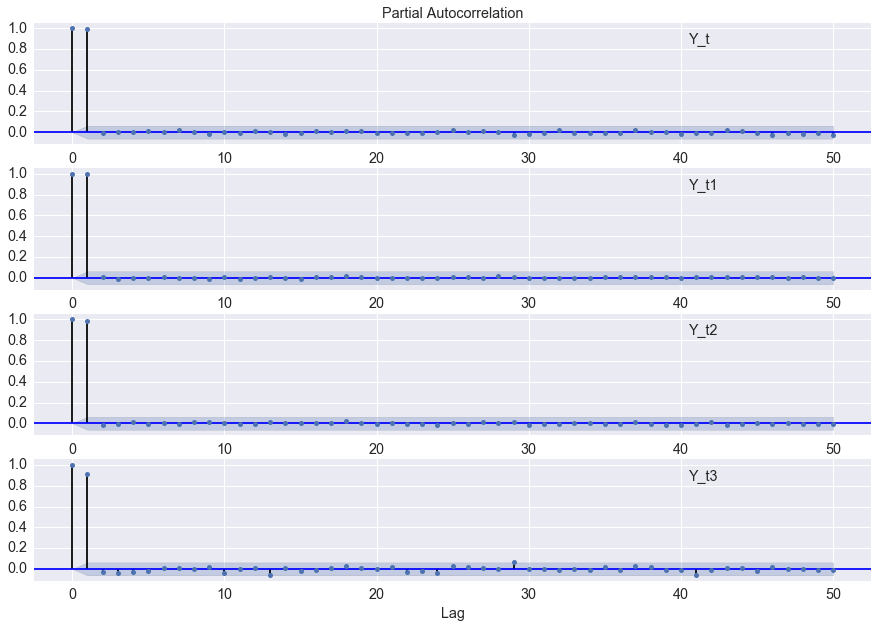

In [56]:
from matplotlib import gridspec
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(1, figsize=(15, 10))
gs = gridspec.GridSpec(4, 1)

for i, y in enumerate(y_list):       
    ax = plt.subplot(gs[i])
    fig = plot_pacf(y, lags=50, alpha=0.05, ax=ax)
    plt.text(x=40.5, y=0.85, s=y.name, size='x-large')
    if i > 0:
        plt.title("")
#     if i < 3:  # set ticks to invisible
#         plt.xticks([])
#     if i == 1:
#         plt.ylabel("Correlation")
    if i == 3:
        plt.xlabel("Lag")

#### ADF

Using as optimal lag _p=1_, we run the ADF test and compare the corresponding t-statistic to the critical values (taken from statsmodels, based on [MacKinnon (2010)](http://statsmodels.sourceforge.net/stable/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller)). The results are summarised in the table below, with perhaps an unexpected result for Y_t3 - the OU process with the largest mean-reversion speed is non-stationary under the ADF test. For the rest is as expected. This highlights the need of carrying additional tests for stationarity instead of just relying on one?

In [470]:
my_result = {}  # result using my implementation
sm_result = {}  # statsmodels result

for i, y in enumerate(y_list):
    my_result[y.name] = my_adfuller(y, maxlag=1, regression='c')
    sm_result[y.name] = adfuller(x=y, maxlag=1, regression='c', autolag=None, regresults=True)
    # Also do it for the differences, note different lag used
    my_result['d' + y.name] = my_adfuller(y.diff().dropna(), maxlag=0, regression='c')
    sm_result['d' + y.name] = adfuller(x=y.diff().dropna(), maxlag=0, regression='c', autolag=None, regresults=True)

# Print results
for key in my_result.keys():
    print "{0}: {1:.4f}".format(key, my_result[key]['adfstat'])
    print sm_result[key]
    print "pvalue=%0.4g" % sm_result[key][1]

dY_t2: -29.3639
(-29.36390932844888, 0.0, {'5%': -2.864437475834273, '1%': -3.4369127451400474, '10%': -2.568312754566378}, <statsmodels.tsa.stattools.ResultsStore object at 0x000000002BA8E198>)
pvalue=0
dY_t1: -29.4587
(-29.458702182847425, 0.0, {'5%': -2.864437475834273, '1%': -3.4369127451400474, '10%': -2.568312754566378}, <statsmodels.tsa.stattools.ResultsStore object at 0x000000002DEE00F0>)
pvalue=0
dY_t3: -31.3506
(-31.350558750248219, 0.0, {'5%': -2.864437475834273, '1%': -3.4369127451400474, '10%': -2.568312754566378}, <statsmodels.tsa.stattools.ResultsStore object at 0x000000002F1B01D0>)
pvalue=0
Y_t: 0.1093
(0.10928529332167412, 0.96668935601503581, {'5%': -2.864437475834273, '1%': -3.4369127451400474, '10%': -2.568312754566378}, <statsmodels.tsa.stattools.ResultsStore object at 0x000000002CB5C9E8>)
pvalue=0.9667
Y_t1: -6.0020
(-6.0020080361970347, 1.6488401737025808e-07, {'5%': -2.864437475834273, '1%': -3.4369127451400474, '10%': -2.568312754566378}, <statsmodels.tsa.statt

| Process | Theta | ADF t-stat | 5% Crit. Val. | p-value  | Stationary | Stable |
|---------|-------|------------|---------------|----------|------------|--------|
| Y_t     | 0     | 0.1093     | -2.8644       | 0.9667   | No         | Yes    |
| Y_t1    | 0.003 | -6.0020    | -2.8644       | 1.65E-07 | Yes        | Yes    |
| Y_t2    | 0.01  | -8.7597    | -2.8644       | 2.69E-14 | Yes        | Yes    |
| Y_t3    | 0.1   | -10.1133   | -2.8644       | 9.87E-18 | Yes        | Yes    |
| dY_t    | 0     | -31.8476   | -2.8644       | 0.0      | Yes        | No     |
| dY_t1   | 0.003 | -29.4587   | -2.8644       | 0.0      | Yes        | Yes    |
| dY_t2   | 0.01  | -29.3639   | -2.8644       | 0.0      | Yes        | Yes    |
| dY_t3   | 0.1   | -31.3506   | -2.8644       | 0.0      | Yes        | No     |

#### Stability Check

To ensure further the reliability of results, a stability check can be done on the estimated coefficients by looking at their eigenvalues within the unit circle (see Appendix for details). The results of the self-implementation are displayed in the table above. All cases were found stable, except dY_t and dY_t3. This demonstrates that stationarity does not imply stability. The unstable nature of dY_t may be due to the drift term added $dY_t = \alpha + \epsilon_t$. A close inspection of the problematic root of dY_t3 shows it is just right on the boundary of the unit circle.

In [475]:
for key in my_result.keys():
#     print key, my_result[key]['roots'], sm_result[key][3].roots
    print key, np.abs(my_result[key]['roots'])
    print "{0} passes stability check: {1}".format(key, is_stable(my_result[key]['roots']))

dY_t2 [  1.13343394  22.21695591]
dY_t2 passes stability check: True
dY_t1 [  1.01435783  17.50069413]
dY_t1 passes stability check: True
dY_t3 [   0.99769382  114.54000516]
dY_t3 passes stability check: False
Y_t [ 2.24454786  2.24454786  2.29331194]
Y_t passes stability check: True
Y_t1 [ 2.71044769  3.15598108  3.15598108]
Y_t1 passes stability check: True
Y_t2 [ 2.06150444  2.07651681  2.07651681]
Y_t2 passes stability check: True
Y_t3 [ 1.00769613  1.00769613  1.05473821]
Y_t3 passes stability check: True
dY_t [  0.91600204  11.98589696]
dY_t passes stability check: False


### Other useful plots

When assessing stationarity, the below plots could also be used (see [pandas ref1](http://pandas.pydata.org/pandas-docs/stable/visualization.html#autocorrelation-plot), [pandas ref2](https://github.com/pydata/pandas/blob/master/pandas/tools/plotting.py)):

* **Autocorrelation plot:** this shows the autocorrelation function (ACF) at varying time lags. For perfectly stationary series or iid random variables, the autocorrelations should be near zero for all time-lag separations. The horizontal lines displayed in the plot correspond to 95% and 99% C.L. Indeed in the example below none of the  differenced processes show significant autocorrelation. Also the OU process with the highest mean-reversion speed Y_t3 rapidly looses autocorrelation to its lags, looking more like stationary.

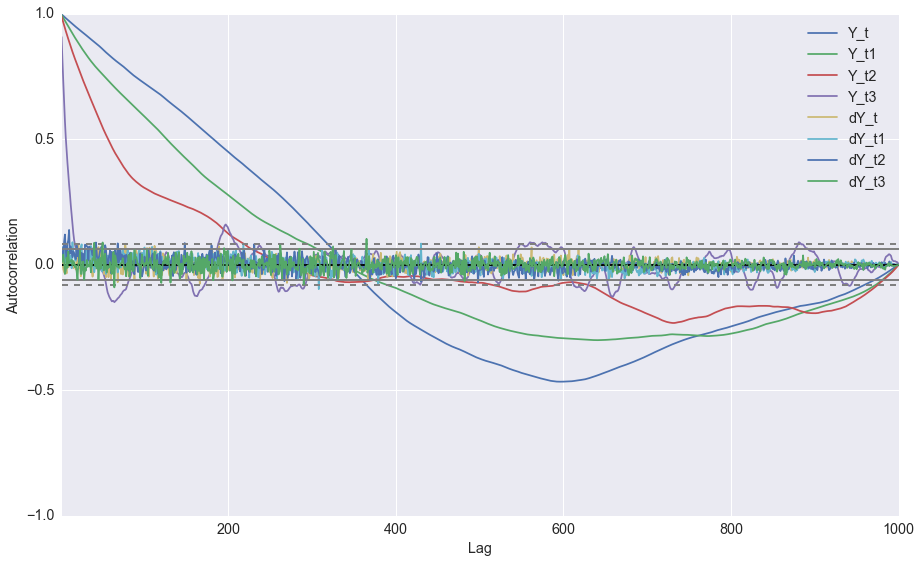

In [356]:
from pandas.tools.plotting import autocorrelation_plot

p_list = [Y_t, Y_t1, Y_t2, Y_t3]

plt.figure(1, figsize=(15, 5))

for i, p in enumerate(p_list):
    autocorrelation_plot(p[1:], label=p.name)

for i, p in enumerate(p_list):
    autocorrelation_plot(p.diff().dropna(), label='d'+p.name)


* **Lag plot:** this is a scatter plot between the series $Y_t$ and one of its lags $Y_{t-p}$. Like in the autocorrelation plot, a stationary series would not exhibit any relationship. Below an example is shown for two of the OU processes and their differences. This confirms the results from the autocorrelation plot - the fastes mean-reverting Y_t3 has little relation to the 10th lag, unlike Y_t1 which has a lower speed. As expected, the stationary differences are insensitive to the lags, even for $Y_{t-1}$.


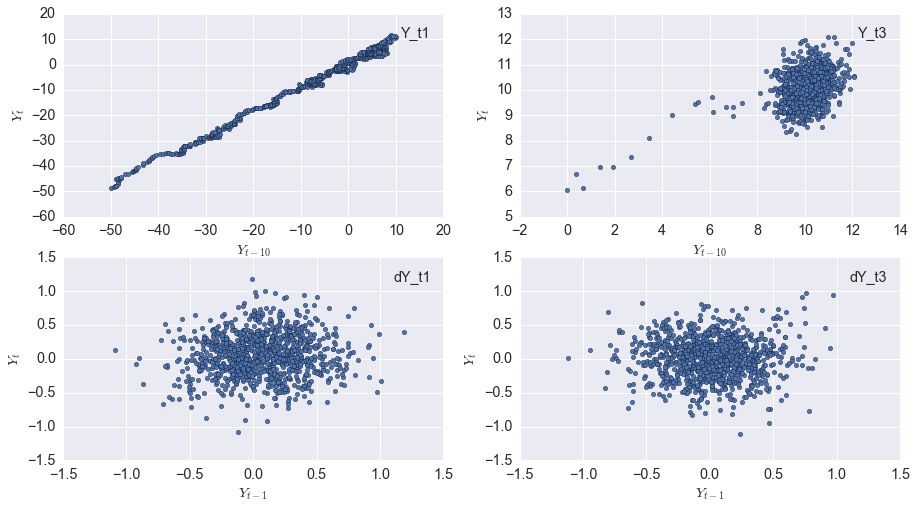

In [421]:
from pandas.tools.plotting import lag_plot

from matplotlib import gridspec

plt.figure(1, figsize=(15, 8))
gs = gridspec.GridSpec(2, 2)

lag_plot(Y_t1, lag=10, ax=plt.subplot(gs[0]), label='Y_t1')
plt.legend(markerscale=0)
plt.xlabel(r'$Y_{t-10}$')
plt.ylabel('$Y_{t}$')
lag_plot(Y_t3, lag=10, ax=plt.subplot(gs[1]), label='Y_t3')
plt.legend(markerscale=0)
plt.xlabel(r'$Y_{t-10}$')
plt.ylabel('$Y_{t}$')
lag_plot(Y_t1.diff().dropna(), lag=1, ax=plt.subplot(gs[2]), label='dY_t1')
plt.legend(markerscale=0)
plt.xlabel(r'$Y_{t-1}$')
plt.ylabel('$Y_{t}$')
lag_plot(Y_t3.diff().dropna(), lag=1, ax=plt.subplot(gs[3]), label='dY_t3')
plt.legend(markerscale=0)
plt.xlabel(r'$Y_{t-1}$')
plt.ylabel('$Y_{t}$')

# Cointegration

Having covered the key concepts to understand cointegration, we proceed to explain this topic.

Two or more time series $\mathbf{Y}_t = (y_{1t}, \dots, y_{nt})^\prime $ are said to be cointegrated if a linear combination exists which makes the collection "integrated of order zero" I(0) i.e stationary:

$$
\mathbf{\beta^\prime Y}_t = \beta_1 y_{1t} + \dots + \beta_n y_{nt} \sim I(0)
$$

This is known as the _long-run (static) equilibrium_ model and is expressed in normalised form as:

$$
y_{1t} = \beta_2 y_{2t} + \dots + \beta_n y_{nt} + e_t
$$

where the residual $e_t \sim I(0)$ is referred to as the _cointegrating residual/spread_ and $\mathbf{\beta} = (1, -\beta_2, \dots, -\beta_n)^\prime$ is the _cointegrating vector_.

Due to time constrains, this report only covers only a pair of cointegrated time series, however the concept can be extended to more series and higher orders of integration.

In real data, cointegration ususally exists when there is a deep economic link between the assets and hence these cannot drift too far apart because economic forces will act to restore the long-run equilibrium. The figure below shows a simulated pair of cointegrated assets $y_{1t}$ and $y_{2t}$, where $y_{2t}$ is defined as an I(1) process.  If $y_{1t}$ is supposed to have a strong link to $y_{2t}$, the price of $y_{1t}$ should vary similarly. This is simulated by shifting up $y_{2t}$ and adding some noise (residual) drawn from a normal distribution, so $y_{1t}$ is defined as the dependent variable and $y_{2t}$ as the independent variable:

$$
y_{1t} = y_{2t} + 5.0 + \epsilon_t
$$

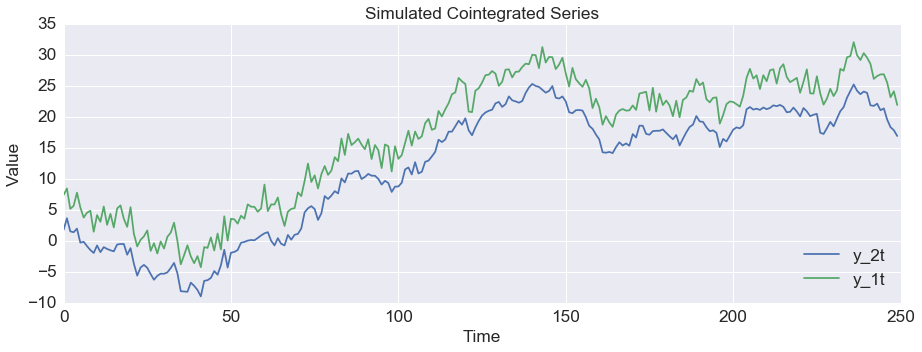

In [6]:
N = 250 # length of series

np.random.seed(2000)

# Generate a stationary random y_2t
y_2t = np.random.normal(0, 1, N)
# Integrate it to make it I(1)
y_2t = np.cumsum(y_2t)
y_2t = pd.Series(y_2t)
y_2t.name = 'y_2t'  # independent variable

# Make an y_1t that is y_2t plus some noise
some_noise = np.random.normal(0, 1, N)
shift = 5.0
y_1t = y_2t + shift + some_noise
y_1t.name = 'y_1t'  # dependent variable

plt.plot(y_2t)
plt.plot(y_1t)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Simulated Cointegrated Series')
plt.legend([y_2t.name, y_1t.name], loc='lower right');

## Tests

Again, we need a robust statistical test to confirm cointegration. The three main approaches are:

* **Engle–Granger two-step method:** this can only be used to test a _single_ cointegrating relationship. The steps are: 

    (i) Estimate the cointegrating residual $ \hat{e}_t = \mathbf{\hat{\beta}^\prime} \mathbf{Y}_t$, e.g. using linear regression

    (ii) Test $\hat{e}_t$ for stationarity, e.g. using the ADF test, where the hypotheses to be tested are:

    $$
    \begin{equation}
    H_0 \space :  \space \hat{e}_t = \mathbf{\hat{\beta}^\prime} \mathbf{Y}_t \sim I(1) \qquad \mathrm{(no \space cointegration)} \\
    H_1 \space :  \space \hat{e}_t = \mathbf{\hat{\beta}^\prime} \mathbf{Y}_t \sim I(0) \qquad \mathrm{(cointegration)}
    \end{equation}
    $$
   
   We refer to this use case of the ADF as 'CADF'
   

* **Johansen test:** based on maximum likelihood techniques, this allows for more than one cointegrating relationship, but  it is subject to asymptotic conditions when if the sample size is too small


* **Phillips–Ouliaris test:** uses a modified version of the Dickey-Fuller distribution to test the cointegrating spread for stationarity. This is a better choice when dealing with small samples

In this project only the Engle-Granger two-step method is considered.

### Engle-Granger test implementation

For our simulated cointegrated series, the cointegration relationship is then repesented by the regression:

$$
y_{1t} = c + \beta_2^\prime y_{2t} + e_t
$$

whose parameters are estimated  using OLS. Hence, the estimated cointegrating spread is:

$$
\hat{e}_t = y_{1t} - \hat{c} - \hat{\beta}_2^\prime y_{2t}
$$

We then test $\hat{e}_t$ for stationarity using ADF.  Since the mean of $\hat{e}_t$ is zero, the ADF can be implemented without a constant or trend (See [ref p445](file:///C:/Users/Tanya.Sandoval/Downloads/Cointegration%20-%20Book%20Chapter%20-%20UWashington%20E%20Zivot.pdf)). Also note that the critical values used are taken as in statsmodels from MacKinnon (2010) [(see ref)](http://statsmodels.sourceforge.net/stable/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller), whereas other sources suggest to use the Phillips-Ouliaris tabulation in this case.

The figure below shows the OLS fit:

$$
\hat{y}_{1t} = 5.0330 + 1.0052 y_{2t} + \hat{e}_t
$$

which is in good agreement with its true value. Plotted also is the estimated $\hat{e}_t$ and its PACF. The PACF shows the spread is  _memoryless_, i.e. no lag order appears significant so it's a random (Markov) process. 

Although $\hat{e}_t$ appeared memoryless, conservatively the CADF t-statistic was computed using one lag. This was $-12.051$, which was below the $1\%$ critical value ($-2.5748$), confirming the stationarity of the spread, which by design we expected.

In [374]:
# ======  ENGLE-GRANGER 2-STEP METHOD  ======

# ===== STEP 1: GET SPREAD FROM OLS =====

# My OLS and ADF implementatin
from analysis import my_OLS

# Import statsmodels equivalents to validate results
from statsmodels.tsa.tsatools import add_constant
from statsmodels.regression.linear_model import OLS

y_2t = add_constant(y_2t)
my_res_ols = my_OLS(y_1t, y_2t)
sm_res_ols = OLS(y_1t, y_2t).fit()  # validate result with statsmodels
y_2t = y_2t.iloc[:, 1]  # remove the constant now that we're done

# Set values of estimated parameters
c_hat = my_res_ols['params'][0]
beta2_hat = my_res_ols['params'][1]

# cointegration spread
e_t_hat = y_1t - c_hat - beta2_hat*y_2t  # == sm_res_ols.resid ==  my_res_ols['resid_hat']
e_t_hat.name = 'e_t_hat'

# print my_res_ols['params']
# print sm_res_ols.params
sm_res_ols.summary2()
# print my_res_ols['resid_hat'].head()
# print sm_res_ols.resid.head()
# print e_t_hat.head()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.990    
Dependent Variable: y_1t             AIC:                725.9157 
Date:               2016-07-24 13:06 BIC:                732.9586 
No. Observations:   250              Log-Likelihood:     -360.96  
Df Model:           1                F-statistic:        2.412e+04
Df Residuals:       248              Prob (F-statistic): 4.58e-249
R-squared:          0.990            Scale:              1.0595   
---------------------------------------------------------------------
         Coef.     Std.Err.       t        P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const    5.0330      0.1000     50.3359    0.0000    4.8360    5.2299
y_2t     1.0052      0.0065    155.2941    0.0000    0.9924    1.0179
------------------------------------------------------------------
Omnibus:              2.007         Durbin-Watson:           2.217
Prob(Omnibus):        0.367         Jarque-Bera (JB):        1.696
Skew:                 -0.059        Prob(JB):                0.428
Kurtosis:             2.614         Condition No.:           24   
==================================================================

"""

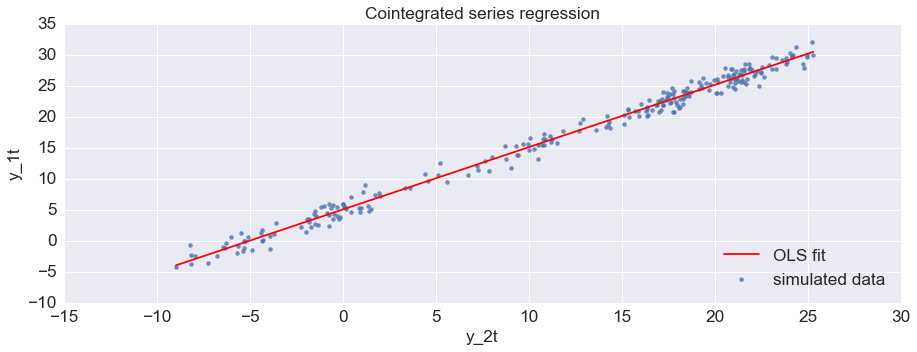

In [375]:
# ===== PLOT OLS FIT  =====

# generate equally spaced X values between true X range
x = np.linspace(y_2t.min(), y_2t.max(), 100)

# Plot the estimated dependent variable
y_1t_hat = c_hat + beta2_hat*x

# Plot own fit on top of seaborn scatter + fit
plt.title('Cointegrated series regression')
ax = sns.regplot(x=y_2t, y=y_1t, fit_reg=False)  # true values
ax.plot(x, y_1t_hat, 'r')
plt.legend(['OLS fit', 'simulated data'], loc='lower right')

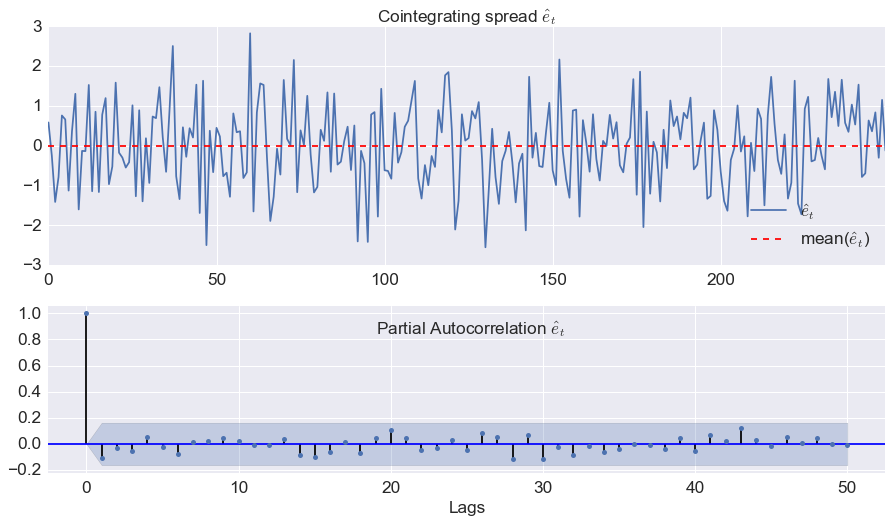

In [378]:
# ===== CHECK OPTIMAL LAG ORDER  =====
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import gridspec

plt.figure(1, figsize=(15, 8))
# gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 0.7])

# Plot cointegrated residual
plt.subplot(gs[0])
plt.title('Cointegrating spread $\hat{e}_t$')
e_t_hat.plot()
plt.axhline(e_t_hat.mean(), color='red', linestyle='--') # Add the mean
plt.legend(['$\hat{e}_t$', 'mean($\hat{e}_t$)'], loc='lower right')
plt.xlabel('')

axx = plt.subplot(gs[1])
_ = plot_pacf(e_t_hat, lags=50, alpha=0.01, ax=axx)
# plt.title('Partial Autocorrelation $\hat{e}_t$')
plt.xlabel('Lags')
plt.title('')
plt.text(x=19, y=0.85, s='Partial Autocorrelation $\hat{e}_t$', size='x-large')

In [46]:
# ======  ENGLE-GRANGER 2-STEP METHOD  ======

# ===== STEP 2: ADF TEST ON SPREAD  =====

from analysis import my_adfuller
from statsmodels.tsa.stattools import adfuller

# Test spread for stationarity with ADF assuming maxlag=1
my_res_adf = my_adfuller(e_t_hat, maxlag=1, regression='nc')

# Validate result with statsmodels
sm_res_adf = adfuller(e_t_hat, maxlag=1, regression='nc', autolag=None, regresults=True)

print sm_res_adf
print my_res_adf['adfstat']
# print "%0.4f" % my_res_adf['adfstat']

(-12.050868021596958, 5.7204620264072049e-22, {'5%': -1.9421357293965669, '1%': -2.5748142943548387, '10%': -1.6157914965824409}, <statsmodels.tsa.stattools.ResultsStore object at 0x000000001012D710>)
-12.0508680216


## Error Correction Model (ECM)

Cointegration implies the existence of an Error Correction Model (ECM), which  provides an adjustment to the long-run equilibrium from the short-run dynamics. This is particularly useful when modelling non-stationary series, like market prices, which can lead to spurious regression results. 

Suppose the cointegrated pair is represented by $\mathbf{Y}_t = (y_t, x_t)^\prime $. One can arrive at the ECM result as follows:

* Consider a dynamic regression model to allow for a wide variety of dynamic patterns in the data. This is done by including lags for both $x_t$ and $y_t$:

$$
y_t = \alpha y_{t-1} +  \beta_0 + \beta_1 x_t + \beta_2 x_{t-1} + \epsilon_t
$$

* By knowing the above equation should be consistent with the long-run equilibrium model $y_t = b_0 + b_1 x_t + e_t$, it can be rewritten as:

    $$
    \Delta y_{t} = \beta_1 \Delta x_t - (1- \alpha) e_{t-1} + \epsilon_t
    $$
    
    where $e_{t-1}$ is the lagged cointegrating spread from the equilbrium model. The parameter $-(1-\alpha)$ is interpreted as the speed of correction towards the equilibrium level (more detais on next section)
    
    
*  Since all the variables in the ECM are I(0), OLS can be used to estimate the parameters


## Quality of mean-reversion

If the cointegrating spread $e_t$ is stationary, we could use the OU process to model it:

$$
d e_t = \theta (\mu_e - e_t) dt + \sigma dW
$$

In discrete time this can be written as:

$$ 
\begin{equation}
\Delta e_t = \alpha \mu_e - \alpha e_{t-1} + \epsilon_{t, \tau}
\end{equation}
$$

where $\alpha= 1 - e^{-\theta \tau}$ and $\tau$ is a small period of time. This is in fact the  implied ECM representation for $e_t$. As disussed in the Appendix, the above equation can be written in it's AR(1) representation as:

$$
e_t = \alpha \mu_e + (1-\alpha)e_{t-1} + \epsilon_{t, \tau}
$$

Rewriting in terms of $C = \alpha \mu_e$ and $B=1-\alpha$ we see it is a simple regression which can be determined with OLS:

$$ 
\begin{equation}
e_t = C + B e_{t-1} + \epsilon_{t, \tau} \\
\end{equation}
$$

In particular, to assess the quality of the spread for trading strategies the parameters of interest are:

$$
\theta = -\frac{\ln B}{\tau} \qquad \mu_e = \frac{C}{1-B} 
\quad \sigma_{OU} = \sqrt{\frac{2 \theta}{1-e^{-2\theta \tau}} Var[\epsilon_{t, \tau}]}
$$

* $\mu_e$ is the long-run equilibrium level of the OU process 

* The mean-reversion speed $\theta$ can be translated into a half-life $\tilde{\tau} \propto \ln 2 / \theta $, which is the time between equilibrium situations, i.e. when $e_t = \mu_e$. Hence, a high $\theta$ (small $\tilde{\tau}$) is desirable to trigger trading signals

* The standard deviation defined as   $\sigma_{eq} =  \sigma_{OU} / \sqrt{2 \theta}$  can be used to plot trading bounds for entry/exit signals as $\mu_e \pm \sigma_{eq}$

* Here we use $\tau = 1/252$ given our data has daily frequency and the in-sample period covers 1 trading year i.e. $\sim 252$ trading days

## Real Data Example

We now proceed to apply the concepts discussed above to real data:

* We use the in-sample dataset for Brent crude and Gasoil (Jan-2014 to Dec-2014). The out-of-sample dataset is later used to backtest trading strategies

* For now we assume Brent is the independent variable $x_t$ and Gasoil the dependent variable $y_t$, and later check if this is accurate via _Granger's causality test_

In [65]:
x = df_is['brent']  # explanatory variable ('X')
y = df_is['gasoil']  # dependent variable ('Y')
print x.head()
print y.head()

Date
2014-01-02    107.78
2014-01-03    106.89
2014-01-06    106.73
2014-01-07    107.35
2014-01-08    107.15
Name: brent, dtype: float64
Date
2014-01-02    123.959732
2014-01-03    122.181208
2014-01-06    122.181208
2014-01-07    122.214765
2014-01-08    122.449664
Name: gasoil, dtype: float64


### Stationarity

First we check the individual price series for unit root I(1) as we would expect. We apply the ADF test using one lag only as recommended by their PACF plot below. A drift term (constant) is also included in the test. The results are summarised in the table below and support Brent and Gasoil are I(1) processes whilst their differences are I(0).

| Series     | ADF t-stat | 5% Crit. Val. | p-value  | Stationary | Stable |
|------------|------------|---------------|----------|------------|--------|
| $x_t$ (Brent)  | 3.5768     | -2.8728       | 1.00     | No         | No     |
| $y_t$ (Gasoil) | 3.9374     | -2.8728       | 1.00     | No         | No     |
| $\Delta x_t$         | -18.1437   | -2.8728       | 2.49E-30 | Yes        | Yes    |
| $\Delta y_t$         | -18.9247   | -2.8728       | 0.00     | Yes        | Yes    |

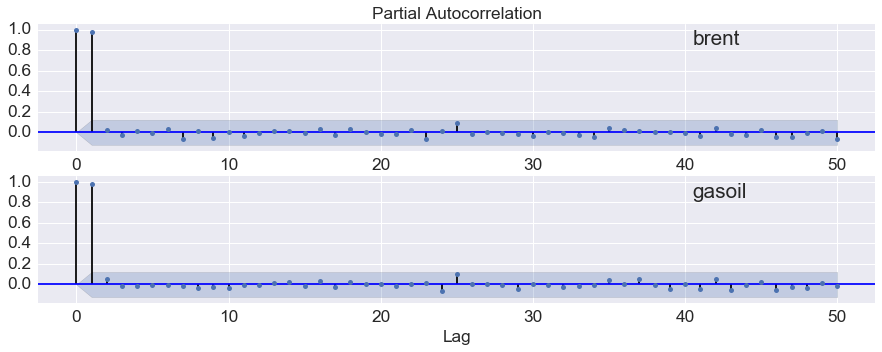

In [66]:
# ======  OPTIMAL LAG SELECTION FROM PACF  ======

from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import gridspec

plt.figure(1, figsize=(15, 5))
gs = gridspec.GridSpec(2, 1)

s_list = [x, y]

for i, s in enumerate(s_list):
    ax = plt.subplot(gs[i])
    fig = plot_pacf(s, lags=50, alpha=0.05, ax=ax)
    plt.text(x=40.5, y=0.85, s=s.name, size='xx-large')
    if i > 0:
        plt.title("")
#     if i < 3:  # set ticks to invisible
#         plt.xticks([])
#     if i == 1:
#         plt.ylabel("Correlation")
    if i == len(s_list) - 1:
        plt.xlabel("Lag")    

In [67]:
# ======  ADF TEST ON I(1) SERIES  ======

my_result = {}  # result using my implementation
sm_result = {}  # statsmodels result

for i, s in enumerate(s_list):
    my_result[s.name] = my_adfuller(s, maxlag=1, regression='c')
    sm_result[s.name] = adfuller(x=s, maxlag=1, regression='c', autolag=None, regresults=True)
    # Also do it for the differences, note different lag used
    my_result['d' + s.name] = my_adfuller(s.diff().dropna(), maxlag=0, regression='c')
    sm_result['d' + s.name] = adfuller(x=s.diff().dropna(), maxlag=0, regression='c', autolag=None, regresults=True)

# Print results
for key in my_result.keys():
    print "{0}: {1:.4f}".format(key, my_result[key]['adfstat'])
    print sm_result[key]
    print "pvalue=%0.4g" % sm_result[key][1]

dbrent: -18.1437
(-18.143719264743723, 2.4867756476974896e-30, {'5%': -2.8728972266578676, '1%': -3.4561550092339512, '10%': -2.5728222369384763}, <statsmodels.tsa.stattools.ResultsStore object at 0x0000000012CAE748>)
pvalue=2.487e-30
dgasoil: -18.9247
(-18.924720011933648, 0.0, {'5%': -2.8728972266578676, '1%': -3.4561550092339512, '10%': -2.5728222369384763}, <statsmodels.tsa.stattools.ResultsStore object at 0x0000000012C72F98>)
pvalue=0
brent: 3.5768
(3.5767945729466528, 1.0, {'5%': -2.8728972266578676, '1%': -3.4561550092339512, '10%': -2.5728222369384763}, <statsmodels.tsa.stattools.ResultsStore object at 0x000000001313E160>)
pvalue=1
gasoil: 3.9374
(3.9373561613700625, 1.0, {'5%': -2.8728972266578676, '1%': -3.4561550092339512, '10%': -2.5728222369384763}, <statsmodels.tsa.stattools.ResultsStore object at 0x0000000013134AC8>)
pvalue=1


In [68]:
# ======  STABILITY CHECK  ======

from analysis import is_stable

for key in my_result.keys():
#     print key, my_result[key]['roots'], sm_result[key][3].roots
    print key, np.abs(my_result[key]['roots'])
    print "{0} passes stability check: {1}".format(key, is_stable(my_result[key]['roots']))

dbrent [ 1.13645384  4.02521074]
dbrent passes stability check: True
dgasoil [ 1.11295032  3.67944752]
dgasoil passes stability check: True
brent [ 0.7871362   0.7871362   0.84225308]
brent passes stability check: False
gasoil [ 0.71964521  0.71964521  0.77280026]
gasoil passes stability check: False


### Cointegration

We then proceed to test whether the pair is cointegrated, using the Engle-Granger two-step procedure previously described. 

* The long-run equilibrium model is shown in the figure below. The OLS estimate  was:

    $$
     \hat{y}_x = 16.3229 + 0.9699 x_t + \hat{e}_t
    $$

    with goodness-of-fit $R^2=0.986$. 

In [8]:
# ======  ENGLE-GRANGER 2-STEP METHOD  ======

# ===== STEP 1: GET SPREAD FROM OLS =====

# My OLS and ADF implementatin
from analysis import my_OLS

# Import statsmodels equivalents to validate results
from statsmodels.tsa.tsatools import add_constant
from statsmodels.regression.linear_model import OLS

# Define variables
x = df_is['brent']  # explanatory variable ('X')
y = df_is['gasoil']   # dependent variable ('Y')

# Do OLS
x = add_constant(x)
my_res_ols = my_OLS(y, x)
sm_res_ols = OLS(y, x).fit()  # validate result with statsmodels
x = x.iloc[:, 1]  # remove the constant now that we're done

# Set values of estimated parameters
c_hat = my_res_ols['params'][0]
beta2_hat = my_res_ols['params'][1]
# cointegration spread, should be == sm_res_ols.resid ==  my_res_ols['resid_hat']
e_t_hat = y - c_hat - beta2_hat*x
e_t_hat.name = 'e_t_hat'

# print my_res_ols['params']
# print sm_res_ols.params
# print e_t_hat.mean()
sm_res_ols.summary2()
# print my_res_ols['resid_hat'].head()
# print sm_res_ols.resid.head()
# print e_t_hat.head()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.986    
Dependent Variable: gasoil           AIC:                998.0839 
Date:               2016-07-23 17:33 BIC:                1005.1898
No. Observations:   258              Log-Likelihood:     -497.04  
Df Model:           1                F-statistic:        1.846e+04
Df Residuals:       256              Prob (F-statistic): 1.25e-240
R-squared:          0.986            Scale:              2.7814   
--------------------------------------------------------------------
           Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const     16.3229     0.7174    22.7540   0.0000   14.9102   17.7356
brent      0.9699     0.0071   135.8850   0.0000    0.9558    0.9839
------------------------------------------------------------------
Omnibus:              1.331         Durbin-Watson:           0.350
Prob(Omnibus):        0.514         Jarque-Bera (JB):        1.346
Skew:                 -0.172        Prob(JB):                0.510
Kurtosis:             2.917         Condition No.:           694  
==================================================================

"""

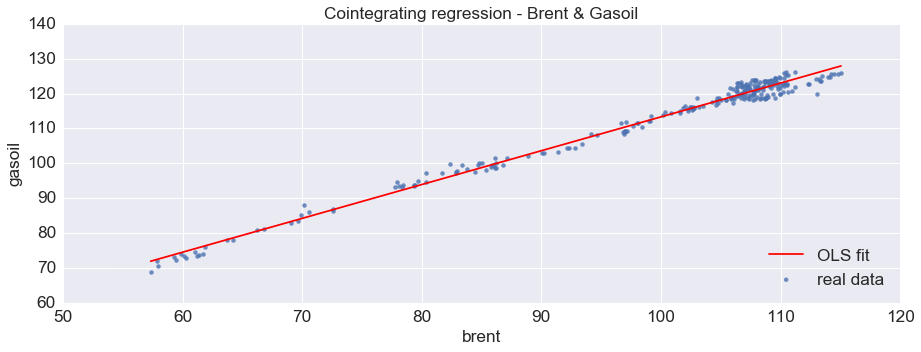

In [71]:
# ===== PLOT OLS FIT  =====

# generate equally spaced X values between true X range
x_dummy = np.linspace(x.min(), x.max(), 100)

# Plot the estimated dependent variable
y_hat = c_hat + beta2_hat*x_dummy

# Plot own fit on top of seaborn scatter + fit
plt.title('Cointegrating regression - Brent & Gasoil')
ax = sns.regplot(x, y, fit_reg=False)  # true values
ax.plot(x_dummy, y_hat, 'r')
plt.legend(['OLS fit', 'real data'], loc='lower right')

* The estimated cointegrating spread $\hat{e}_t$ series, histogram and PACF are shown below. First the mean of  $\hat{e}_t$ is for all practical purposes zero ($\sim10^{-13}$). 


* We also want $\hat{e}_t$ to be normally distributed. The histogram below shows the spread distribution fitted to a normal distribution with $\mu \sim 0$ and $\sigma=1.66$. Two tests (_Lilliefors_ and _Anderson-Darling_, see [ref1](http://statsmodels.sourceforge.net/notebooks/generated/statsmodels.stats.diagnostic.normal_ad.html) and [ref2](http://statsmodels.sourceforge.net/devel/generated/statsmodels.stats.diagnostic.kstest_normal.html)) were carried to assess the goodness of fit and neither rejected the null hypothesis that $\hat{e}_t$ is normally distributed


* Next, we note that the PACF plot shows a peculiarity of this spread - it seems to have an AR(3) 'memory', given the first three lags appear significant. Memory in the cointegrating spread is actually _not desirable_ because it will interfere with both mean-reversion and diffusion components of the OU process.  One hypothesis is that this has an 'economic explanation' in terms of commodity pricing, cyclicality or  storage (e.g. asset can’t dramatically drop because there are storage/delivery “carry” costs borne by the sellers)


* Next, $\hat{e}_t$ was tested for stationarity using the CADF test. Since $\hat{\mu}_e \sim 0$  the test was implemented without a constant or trend. Also, as suggested by the PACF plot, the test was ran with 3 lags. The results below show stationary could only be confirmed at the 95% C.L.

| Series | ADF t-stat | 5% Crit. Val. | 1% Crit. Val. | p-value | Stationary     (95% C.L.) | Stable |
|--------|------------|---------------|---------------|---------|---------------------------|--------|
| $\hat{e}_t$    | -2.2335    | -1.9421       | -2.5746       | 0.0245  | Yes                       | Yes    |

mu=2.12116284916e-13, sigma=1.66126722372


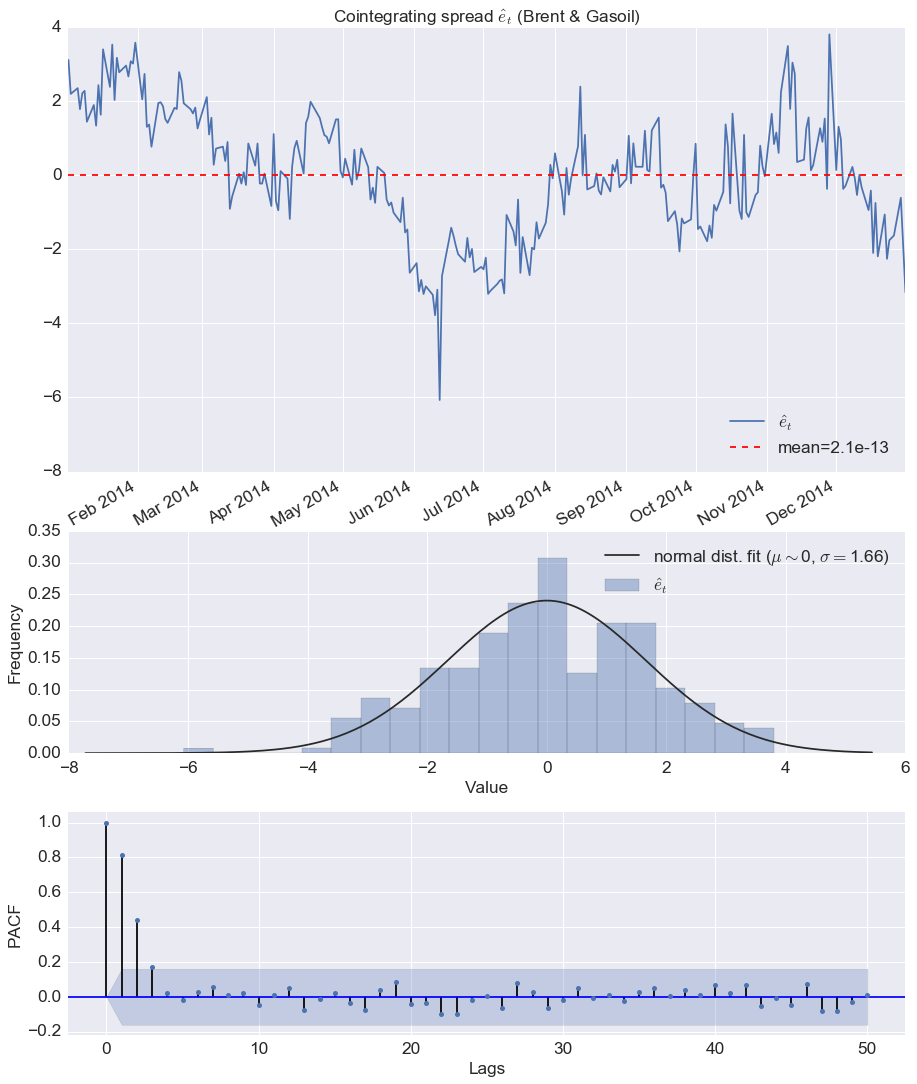

In [109]:
# ===== SPREAD PLOTS  =====

from matplotlib import gridspec

plt.figure(1, figsize=(15, 20))
# gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 0.5, 0.5])

# === SPREAD TIME SERIES ===

plt.subplot(gs[0])
plt.title('Cointegrating spread $\hat{e}_t$ (Brent & Gasoil)')
e_t_hat.plot()
plt.axhline(e_t_hat.mean(), color='red', linestyle='--') # Add the mean
plt.legend(['$\hat{e}_t$', 'mean={0:0.2g}'.format(e_t_hat.mean())], loc='lower right')
plt.xlabel('')

# === SPREAD HISTOGRAM ===

plt.subplot(gs[1])

from scipy import stats

ax = sns.distplot(e_t_hat, bins=20, kde=False, fit=stats.norm);
plt.title('Distribution of Cointegrating Spread for Brent and Gasoil')

# Get the fitted parameters used by sns
(mu, sigma) = stats.norm.fit(e_t_hat)
print "mu={0}, sigma={1}".format(mu, sigma)

# Legend and labels 
plt.legend(["normal dist. fit ($\mu \sim${0}, $\sigma=${1:.2f})".format(0, sigma),
            "$\hat{e}_t$"
           ])
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('')

# # Cross-check this is indeed the case - should be overlaid over black curve
# x_dummy = np.linspace(stats.norm.ppf(0.01), stats.norm.ppf(0.99), 100)
# ax.plot(x_dummy, stats.norm.pdf(x_dummy, mu, sigma))
# plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma),
#            "cross-check"])

# === SPREAD PACF ===

from statsmodels.graphics.tsaplots import plot_pacf

ax = plt.subplot(gs[2])
plot_pacf(e_t_hat, lags=50, alpha=0.01, ax=ax)
plt.title('')
plt.xlabel('Lags')
plt.ylabel('PACF')
# plt.text(x=40.5, y=0.85, s='PACF', size='xx-large')


In [110]:
# ===== GOODNESS OF FIT OF SPREAD TO NORM  ======

# Note: do not use scipy's kstest, 
# see http://stackoverflow.com/questions/7903977/implementing-a-kolmogorov-smirnov-test-in-python-scipy

import statsmodels.api as sm

# Lilliefors test http://en.wikipedia.org/wiki/Lilliefors_test
print 'Lilliefors:', sm.stats.lillifors(e_t_hat)

# Most Monte Carlo studies show that the Anderson-Darling test is more powerful 
# than the Kolmogorov-Smirnov test. It is available in scipy.stats with critical values,
# and in statsmodels with approximate p-values:

print 'Anderson-Darling:', sm.stats.normal_ad(e_t_hat)

Lilliefors: (0.038367676150135144, 0.43182566478813023)
Anderson-Darling: (0.32068246831158831, 0.52946233470021808)


In [111]:
# ===== STEP 2: ADF TEST ON SPREAD  =====

# Test spread for stationarity with ADF assuming maxlag=1, no constant and no trend
my_res_adf = my_adfuller(e_t_hat, maxlag=3, regression='nc')

# Validate result with statsmodels equivalent
sm_res_adf = adfuller(e_t_hat, maxlag=3, regression='nc', autolag=None, regresults=True)

print sm_res_adf
print my_res_adf['adfstat']
print "%0.4f" % my_res_adf['adfstat']

# ===== STABILITY CHECK  =====
print key, np.abs(my_res_adf['roots'])
print "passes stability check: {0}".format(is_stable(my_res_adf['roots']))


(-2.2334740447616901, 0.024528788635871136, {'5%': -1.9421077325749141, '1%': -2.5745985808171614, '10%': -1.6158148499865503}, <statsmodels.tsa.stattools.ResultsStore object at 0x00000000174E6D68>)
-2.23347404476
-2.2335
gasoil [ 1.26791578  1.26791578  4.92804523  8.47920813]
passes stability check: True


### ECM

The corresponding ECM adjustment was determined to be:

$$
\begin{array}{ccc}
\Delta y_{t}  = & -0.0861 + & 0.6455 \Delta x_t -0.1623 e_{t-1} + \epsilon_t \qquad \mathrm{(with~constant,~R^2=0.407)} \\
\Delta y_{t}  = & & 0.6596 \Delta x_t -0.1633 e_{t-1} + \epsilon_t
\qquad \mathrm{(no~constant, ~R^2=0.422)}
\end{array}
$$

This represents the second-order adjustment to the price, which as we see is quite significant.

In [124]:
from statsmodels.regression.linear_model import OLS

Y = y.diff()[1:]  # must remove first element from array which is nan
X = pd.concat([x.diff()[1:], e_t_hat.shift(1)[1:]], axis=1)
X_c = add_constant(X)

sm_res_ecm = OLS(Y, X).fit()  # fit without constant
sm_res_ecm_c = OLS(Y, X_c).fit()  # fit without constant

In [126]:
sm_res_ecm_c.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.407   
Dependent Variable: gasoil           AIC:                665.1503
Date:               2016-07-22 15:52 BIC:                675.7975
No. Observations:   257              Log-Likelihood:     -329.58 
Df Model:           2                F-statistic:        88.92   
Df Residuals:       254              Prob (F-statistic): 5.33e-30
R-squared:          0.412            Scale:              0.77001 
-------------------------------------------------------------------
           Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
-------------------------------------------------------------------
const     -0.0861     0.0556   -1.5468   0.1232   -0.1957    0.0235
brent      0.6455     0.0508   12.7195   0.0000    0.5456    0.7455
e_t_hat   -0.1623     0.0332   -4.8877   0.0000   -0.2277   -0.0969
-----------------------------------------------------------------
Omnibus:              12.768       Durbin-Watson:          2.630 
Prob(Omnibus):        0.002        Jarque-Bera (JB):       30.298
Skew:                 0.056        Prob(JB):               0.000 
Kurtosis:             4.678        Condition No.:          2     
=================================================================

"""

In [125]:
sm_res_ecm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.422   
Dependent Variable: gasoil           AIC:                665.5599
Date:               2016-07-22 15:52 BIC:                672.6580
No. Observations:   257              Log-Likelihood:     -330.78 
Df Model:           2                F-statistic:        94.91   
Df Residuals:       255              Prob (F-statistic): 1.55e-31
R-squared:          0.427            Scale:              0.77422 
-------------------------------------------------------------------
           Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
-------------------------------------------------------------------
brent      0.6596     0.0501   13.1761   0.0000    0.5610    0.7582
e_t_hat   -0.1633     0.0333   -4.9060   0.0000   -0.2288   -0.0977
-----------------------------------------------------------------
Omnibus:              12.488       Durbin-Watson:          2.613 
Prob(Omnibus):        0.002        Jarque-Bera (JB):       29.020
Skew:                 0.064        Prob(JB):               0.000 
Kurtosis:             4.641        Condition No.:          2     
=================================================================

"""

### Quality of mean-reversion

Given the peculiar PACF of $\hat{e}_t$, which suggests it is an AR(3) process, fitting  to the OU process, which is an AR(1) process, might not be suitable. We proceed  nevertheless to compare the results between both fits. For AR(3) we take the OU parameters as for AR(1): the constant term equals $\alpha \mu_e$ and the coefficient of the $e_{t-1}$ term is $\alpha = 1 - e^{-\theta \tau}$. The table below shows the results obtained, where we see the trading bounds are:

$$
 \mu_e \pm \sigma_{eq} =
  \begin{cases}
    -0.1255 \pm  1.6541 & \quad \text{AR(1)} \\
    -0.0529 \pm  0.8820  & \quad \text{AR(3)}\\
  \end{cases}
$$

The AR(3) fit yields a lower standard error in $\theta$ than AR(1), although not by much and yet the $\theta$ values are quite different. This perhaps indicates the OU fit is not suitable regardless of the lag order.

| Process | $\theta$    | $\tilde{\tau}$ | $\mu_e$    | $\sigma_{OU}$ | $\sigma_{eq}$ | $s.e._\theta$ |
|:-------:|:--------:|:---------:|:-------:|:--------:|:-------:|:---------:|
|  AR(1)  |  49.1253 |   0.0141  | -0.1255 |  16.3957 |  1.6541 |   7.3850  |
|  AR(3)  | 258.9327 |   0.0027  | -0.0529 |  20.0723 |  0.8820 |   5.6638  |

In [295]:
# ======  FIT TO OU PROCESS  ======

# My implementations
from analysis import my_AR  # AR(p) model

# Import statsmodels equivalents to validate results
from statsmodels.tsa.ar_model import AR

# Run AR(1) model with constant term with e_t_hat as endogenous variable
my_res_ar = my_AR(endog=e_t_hat, maxlag=1, trend='c')
sm_res_ar = AR(np.array(e_t_hat)).fit(maxlag=3, trend='c', method='cmle')

# Stability Check
print 'is AR({0}) model stable: {1}'.format(sm_res_ar.k_ar, is_stable(sm_res_ar.roots))
print 'is AR({0}) model stable: {1}'.format(my_res_ar['maxlag'], is_stable(my_res_ar['roots']))

# Cross-checks
print "\
AR({12}).fit.params={0} \n MY_AR({13}) params={1} \n\
AR({12}).fit.llf={2} \n MY_AR({13}) llf={3} \n\
AR({12}).fit.nobs={4} \n MY_AR({13}) nobs={5} \n\
AR({12}).fit.cov_params(scale=ols_scale)={6} \n MY_AR({13}) cov_params={7} \n\
AR({12}).fit.bse={8} \n MY_AR({13}) bse={9} \n\
AR({12}).fit.tvalues={10} \n MY_AR({13}) tvalue={11} \n\
AR({12}).fit.k_ar={12} \n MY_AR({13}) maxlag={13} \n\
".format(
    sm_res_ar.params, my_res_ar['params'],
    sm_res_ar.llf, np.array(my_res_ar['llf']),
    sm_res_ar.nobs, my_res_ar['nobs'],
    sm_res_ar.cov_params(scale=my_res_ar['ols_scale']), my_res_ar['cov_params'],
    sm_res_ar.bse, my_res_ar['bse'],
    sm_res_ar.tvalues, my_res_ar['tvalue'],
    sm_res_ar.k_ar, my_res_ar['maxlag']
)

# Get the fit errors
ar1 = AR(np.array(e_t_hat)).fit(maxlag=1, trend='c', method='cmle')
ar3 = AR(np.array(e_t_hat)).fit(maxlag=3, trend='c', method='cmle')
# print ar1.bse
# print ar3.bse

# Standard error propagation in theta 
# (using formula in https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Simplification )
print 'theta s.e. AR(1) = {0:.4f}'.format(np.sqrt((1./tau*my_B)**2 * (ar1.bse[1])**2))
print 'theta s.e. AR(3) = {0:.4f}'.format(np.sqrt((1./tau*sm_B)**2 * (ar3.bse[1])**2))

is AR(3) model stable: True
is AR(1) model stable: True
AR(3).fit.params=[-0.0339816   0.35789682  0.38033368  0.1825944 ] 
 MY_AR(1) params=[-0.02222121  0.82288261] 
AR(3).fit.llf=-312.345856676 
 MY_AR(1) llf=-348.732777659 
AR(3).fit.nobs=255 
 MY_AR(1) nobs=257 
AR(3).fit.cov_params(scale=ols_scale)=[[  3.49496725e-03   1.12805807e-04  -6.65410304e-06  -1.15724490e-04]
 [  1.12805807e-04   5.09472635e-03  -2.19817515e-03  -2.39060283e-03]
 [ -6.65410304e-06  -2.19817515e-03   4.94828098e-03  -2.23751149e-03]
 [ -1.15724490e-04  -2.39060283e-03  -2.23751149e-03   5.06913477e-03]] 
 MY_AR(1) cov_params=[[  3.46441577e-03  -1.56281520e-05]
 [ -1.56281520e-05   1.26830769e-03]] 
AR(3).fit.bse=[ 0.05201268  0.06279833  0.0618892   0.06264041] 
 MY_AR(1) bse=[ 0.05885929  0.03561331] 
AR(3).fit.tvalues=[-0.65333296  5.6991455   6.14539696  2.91496187] 
 MY_AR(1) tvalue=[ -0.37753101  23.10604287] 
AR(3).fit.k_ar=3 
 MY_AR(1) maxlag=1 

theta s.e. AR(1) = 7.3850
theta s.e. AR(3) = 5.6638

In [12]:
tau = 1. / 252.  # ok for daily frequency data

# AR(1)
my_C = my_res_ar['params'][0]
my_B = my_res_ar['params'][1]
my_theta = - np.log(my_B) / tau
my_mu_e = my_C / (1. - my_B)
my_sigma_ou = np.sqrt((2 * my_theta / (1 - np.exp(-2 * my_theta * tau))) * my_res_ar['sigma'])
my_sigma_e = my_sigma_ou / np.sqrt(2 * my_theta)
my_halflife = np.log(2) / my_theta
print ' AR({8}): my_C={0}, my_B={1}, tau={2}, my_theta={3}, my_mu_e={4}, my_sigma_ou={5}, my_sigma_e={6}, my_halflife={7:.4f}'.format(my_C, 
                                        my_B, 
                                        tau,  
                                        my_theta, 
                                        my_mu_e,
                                        my_sigma_ou,
                                        my_sigma_e,
                                        my_halflife,
                                        my_res_ar['maxlag'])

# AR(3)
sm_C = sm_res_ar.params[0]
sm_B = sm_res_ar.params[1]
sm_theta = - np.log(sm_B) / tau
sm_mu_e = sm_C / (1. - sm_B)
sm_sigma_ou = np.sqrt((2 * sm_theta / (1 - np.exp(-2 * sm_theta * tau))) * sm_res_ar.sigma2)
sm_sigma_e = sm_sigma_ou / np.sqrt(2 * sm_theta)
sm_halflife = np.log(2) / sm_theta
print ' AR({8}): sm_C={0}, sm_B={1}, tau={2}, sm_theta={3}, sm_mu_e={4}, sm_sigma_ou={5}, sm_sigma_e={6}, sm_halflife={7:.4f}'.format(
    sm_C,
    sm_B,
    tau,
    sm_theta,
    sm_mu_e,
    sm_sigma_ou,
    sm_sigma_e,
    sm_halflife,
    sm_res_ar.k_ar)

 AR(1): my_C=-0.0222212062071, my_B=0.822882614599, tau=0.00396825396825, my_theta=49.1253133355, my_mu_e=-0.125460333308, my_sigma_ou=16.3957293292, my_sigma_e=1.65410500427, my_halflife=0.0141
 AR(3): sm_C=-0.0339815972636, sm_B=0.357896821164, tau=0.00396825396825, sm_theta=258.932656877, sm_mu_e=-0.0529223314626, sm_sigma_ou=20.0722726051, sm_sigma_e=0.882039704225, sm_halflife=0.0027


In [175]:
# Equivalent to AR(1) model above but expressed using differences

from statsmodels.regression.linear_model import OLS

Y_e = e_t_hat.diff()[1:]  # de_t
X_e = e_t_hat.shift(1)[1:]  # e_t-1
X_e = add_constant(X_e)
r = OLS(Y_e, X_e).fit()
X_e = X_e.iloc[:, 1]  # remove the constant now that we're done

r.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.085   
Dependent Variable: e_t_hat          AIC:                701.4656
Date:               2016-07-22 18:17 BIC:                708.5637
No. Observations:   257              Log-Likelihood:     -348.73 
Df Model:           1                F-statistic:        24.73   
Df Residuals:       255              Prob (F-statistic): 1.21e-06
R-squared:          0.088            Scale:              0.89031 
-------------------------------------------------------------------
           Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
-------------------------------------------------------------------
const     -0.0222     0.0589   -0.3775   0.7061   -0.1381    0.0937
e_t_hat   -0.1771     0.0356   -4.9733   0.0000   -0.2473   -0.1070
-----------------------------------------------------------------
Omnibus:              12.984       Durbin-Watson:          2.742 
Prob(Omnibus):        0.002        Jarque-Bera (JB):       31.297
Skew:                 0.050        Prob(JB):               0.000 
Kurtosis:             4.707        Condition No.:          2     
=================================================================

"""

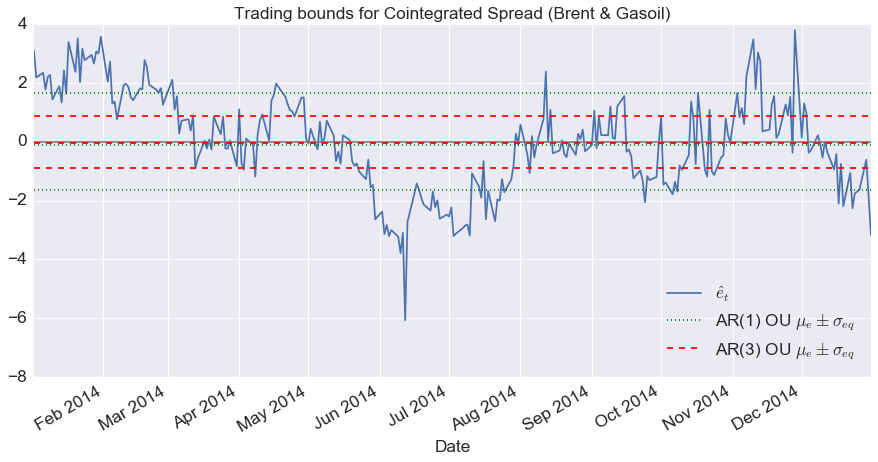

In [296]:
# PLOTTING

e_t_hat.plot(label='$\hat{e}_t$', figsize=(15, 7))
# plt.plot(e_t_hat, label='$\hat{e}_t$')

# Trading bounds
plt.title('Trading bounds for Cointegrated Spread (Brent & Gasoil)')
plt.axhline(0, color='grey', linestyle='-')  # axis line

plt.axhline(my_mu_e, color='green', linestyle=':', label='AR(1) OU $\mu_e \pm \sigma_{eq}$')
plt.axhline(sm_mu_e, color='red', linestyle='--', label='AR(3) OU $\mu_e \pm \sigma_{eq}$')

plt.axhline(my_sigma_e, color='green', linestyle=':')
plt.axhline(-my_sigma_e, color='green', linestyle=':')
plt.axhline(sm_sigma_e, color='red', linestyle='--')
plt.axhline(-sm_sigma_e, color='red', linestyle='--')

plt.legend(loc='lower right')

## Granger Causality

When implementing the cointegrating regression to estimate $e_t$, an assumption must be made about which the dependent variable is. It is actually important to determining the best choice for the independent variable and the dependent variable, as this can largely influence the parameters estimates and test results.

Grange causality means that past values of $x_2$ have a statistically significant effect on the current value of $x_1$, taking past values of $x_1$ into account as regressors. We reject the null hypothesis that $x_2$ does not Granger cause $x_1$ if the pvalues are below a desired size of the test.

Due to time constrains, the ready implementation of [Granger Causality](http://statsmodels.sourceforge.net/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html#statsmodels.tsa.stattools.grangercausalitytests) from statsmodels was used, which uses the F distribution critical values. 

Running the test over the in-sample Brent-Gasoil data using up to 3 lags (which should be enough given theirs PACF plot) yields the results in the table below. This confirms that taking Brent as the independent variable for all cases is acceptable. The hypothesis of Gasoil causing Brent moves is rejected too, which further supports the result.

|                            | F test p-value |        |         |
|:--------------------------:|:--------------:|:------:|:-------:|
|             $H_0$               |      1 lag     | 2 lags |  3 lags |
| Brent doesn't cause Gasoil |     0.0005     | 0.0001 | $< 10^{-4}$ |
| Gasoil doesn’t cause Brent |     0.2315     | 0.2986 |  0.4797 |

In [386]:
df_is[['gasoil', 'brent']].head()

,gasoil,brent
Date,,
2014-01-02,123.959732,107.78
2014-01-03,122.181208,106.89
2014-01-06,122.181208,106.73
2014-01-07,122.214765,107.35
2014-01-08,122.449664,107.15


In [390]:
from statsmodels.tsa import stattools
# Granger causality

# The Null hypothesis for grangercausalitytests is that the time series in the second column, x2,
# does NOT Granger cause the time series in the first column, x1. 
# Grange causality means that past values of x2 have a statistically significant effect on 
# the current value of x1, taking past values of x1 into account as regressors. 
# We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below
# a desired size of the test.

# test whether the time series in the second column Granger causes the time series in the first column
stattools.grangercausalitytests(df_is[['gasoil', 'brent']], maxlag=3)


Granger Causality
('number of lags (no zero)', 1)
ssr based F test:         F=12.3110 , p=0.0005  , df_denom=254, df_num=1
ssr based chi2 test:   chi2=12.4564 , p=0.0004  , df=1
likelihood ratio test: chi2=12.1639 , p=0.0005  , df=1
parameter F test:         F=12.3110 , p=0.0005  , df_denom=254, df_num=1

Granger Causality
('number of lags (no zero)', 2)
ssr based F test:         F=9.5373  , p=0.0001  , df_denom=251, df_num=2
ssr based chi2 test:   chi2=19.4545 , p=0.0001  , df=2
likelihood ratio test: chi2=18.7507 , p=0.0001  , df=2
parameter F test:         F=9.5373  , p=0.0001  , df_denom=251, df_num=2

Granger Causality
('number of lags (no zero)', 3)
ssr based F test:         F=9.6706  , p=0.0000  , df_denom=248, df_num=3
ssr based chi2 test:   chi2=29.8308 , p=0.0000  , df=3
likelihood ratio test: chi2=28.2111 , p=0.0000  , df=3
parameter F test:         F=9.6706  , p=0.0000  , df_denom=248, df_num=3


{1: ({'lrtest': (12.163944250927784, 0.00048722235486658359, 1),
   'params_ftest': (12.310997505212017, 0.00053246127585440358, 254.0, 1L),
   'ssr_chi2test': (12.456402987558841, 0.00041656136528318664, 1),
   'ssr_ftest': (12.310997505213797, 0.00053246127585392078, 254.0, 1)},
   array([[ 0.,  1.,  0.]])]),
 2: ({'lrtest': (18.750722119558645, 8.4787616321132408e-05, 2),
   'params_ftest': (9.5372635776677939, 0.00010182564815372929, 251.0, 2L),
   'ssr_chi2test': (19.454497815799865, 5.9636133077774484e-05, 2),
   'ssr_ftest': (9.5372635776675114, 0.00010182564815375676, 251.0, 2)},
   array([[ 0.,  0.,  1.,  0.,  0.],
          [ 0.,  0.,  0.,  1.,  0.]])]),
 3: ({'lrtest': (28.211133329455606, 3.2796625892383071e-06, 3),
   'params_ftest': (9.6706495866600743, 4.6437170249114676e-06, 248.0, 3L),
   'ssr_chi2test': (29.830834410463282, 1.4978827154663208e-06, 3),
   'ssr_ftest': (9.6706495866599926, 4.643717024911881e-06, 248.0, 3)},
   array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.],

In [389]:
# test whether the time series in the second column Granger causes the time series in the first column
stattools.grangercausalitytests(df_is[['brent', 'gasoil']], maxlag=3)


Granger Causality
('number of lags (no zero)', 1)
ssr based F test:         F=1.4384  , p=0.2315  , df_denom=254, df_num=1
ssr based chi2 test:   chi2=1.4554  , p=0.2277  , df=1
likelihood ratio test: chi2=1.4513  , p=0.2283  , df=1
parameter F test:         F=1.4384  , p=0.2315  , df_denom=254, df_num=1

Granger Causality
('number of lags (no zero)', 2)
ssr based F test:         F=1.2146  , p=0.2986  , df_denom=251, df_num=2
ssr based chi2 test:   chi2=2.4775  , p=0.2897  , df=2
likelihood ratio test: chi2=2.4656  , p=0.2915  , df=2
parameter F test:         F=1.2146  , p=0.2986  , df_denom=251, df_num=2

Granger Causality
('number of lags (no zero)', 3)
ssr based F test:         F=0.8276  , p=0.4797  , df_denom=248, df_num=3
ssr based chi2 test:   chi2=2.5530  , p=0.4658  , df=3
likelihood ratio test: chi2=2.5403  , p=0.4681  , df=3
parameter F test:         F=0.8276  , p=0.4797  , df_denom=248, df_num=3


{1: ({'lrtest': (1.4512730753793903, 0.22832378661890962, 1),
   'params_ftest': (1.4383895986699133, 0.23151771235925203, 254.0, 1L),
   'ssr_chi2test': (1.4553784521978825, 0.22766689122765738, 1),
   'ssr_ftest': (1.4383895986702808, 0.23151771235919735, 254.0, 1)},
   array([[ 0.,  1.,  0.]])]),
 2: ({'lrtest': (2.4655963160421379, 0.29147584007346639, 2),
   'params_ftest': (1.2145595349170704, 0.29857919573389075, 251.0, 2L),
   'ssr_chi2test': (2.4775078959264998, 0.28974503048213451, 2),
   'ssr_ftest': (1.2145595349170926, 0.2985791957338868, 251.0, 2)},
   array([[ 0.,  0.,  1.,  0.,  0.],
          [ 0.,  0.,  0.,  1.,  0.]])]),
 3: ({'lrtest': (2.540261854712071, 0.46805878594719308, 3),
   'params_ftest': (0.82762520417184871, 0.47973549563362006, 248.0, 3L),
   'ssr_chi2test': (2.5529567789981269, 0.46579657968737131, 3),
   'ssr_ftest': (0.82762520417194174, 0.47973549563357443, 248.0, 3)},
   array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  1.

# Issues with Cointegration

* Johansen procedure - MLE for multivariate cointegration on asset price data (levels, not returns)

# Trading Strategies

Below we describe a few strategies which exploit the cointegration properties. It should be noted that it is actually very difficult to find a directly tradable asset that possesses mean-reverting behaviour - in practice this is instead achieved by creating a _stationary portfolio_ of separately interrelated assets. For the demonstrations below however, we remain with a the 2-asset portfolio from before: Brent and Gasoil.

### Regime changes

Tests for cointegration assume that the cointegrating vector is constant during the period of study. In reality, it is possible that the long-run relationship between the underlying variables change (shifts in the cointegrating vector can occur), e.g from changes in their _fundamental factors_. This is especially likely to be the case if the sample period is long. Hence, it shouldn't be assumed that because the assets have passed a cointegration test historically, they will continue to remain cointegrated. Practicioner's advice is to estimate using one year of historic data and trade the estimates for a 6-month period. 

This is then a good introduction to the next topic, which is Backtesting.

### Backtesting

Backtesting is the process of testing a trading strategy or model on historical data to gauge its effectiveness. When we backtest a model, the results achieved are highly dependent on the tested period and this can cause the strategy to fail in the future, as regime changes or _model overfitting_ could have taken place.

To alleviate this, the test data is usually split into  _in-sample_ and _out-of-sample_ (a 'rule-of-thumb' is to use an 80-20 split). The model/strategy is then fitted/tested to the in-sample data _only_ and then tested on the out-of-sample data, which was 'unseen'. This process provides a better way to assess the true performance.

## Naive Beta-Hedging Strategy

** Factor models**  are a way of explaining the returns of one asset via a linear combination of the returns of other assets. This can be expressed as a simple linear regression:

$$\Delta Y = \alpha + \beta_1 \Delta X_1 + \beta_2 \Delta X_2 + \dots + \beta_n \Delta X_n + \epsilon_t $$

We can interpret the betas as the _exposure_ of asset $Y$ to the other assets and $\alpha$ as the market-neutral excess return:

$$ \alpha = \mathrm{E}[\Delta Y - \beta_1 \Delta X_1 + \beta_2 \Delta X_2 + \dots + \beta_n \Delta X_n] $$

since $\mathrm{E}[\epsilon_t] =0$. 

For the case of Brent and Gasoil only this would be:

$$\Delta Y_{gasoil} = \alpha + \beta \Delta X_{brent} + \epsilon_t $$

We could take a short position in Brent equal to $\beta \Delta X_{brent}$ to try to eliminate the _risk_ in our Gasoil position. Hence, we would expect our returns to be on average:

$$\mathrm{E} [\Delta Y_{gasoil} - \beta X_{brent}] = \alpha $$

For the **in-sample** data, running the above regression would actually yield negative returns, although less severe than just going long Gasoil:

$$
\begin{array}{rl}
\mathrm{E} [ \Delta Y_{gasoil}^{is}  -0.6282 \Delta X_{brent}^{is}] =  & \alpha   =  -0.0915 \qquad (R^2 = 0.354) \\
\mathrm{E} [ \Delta Y_{gasoil}^{is}]  =  & \alpha   =   
-0.2148  \qquad  \text{(no fit)}
\end{array}
$$

One problem could be that the estimated beta is not constant as we walk forward in time. As such, the short position we took out in Brent is not perfectly hedging our portfolio. Another is that additional factors or assets should be included into the model.

Surprisingly, our performance in the **out-of-sample** seems to be better but that was just mere 'luck' from positive fluctuations in the data, and still worse off than going long just Gasoil over this period:

$$
\begin{array}{rl}
\mathrm{E} [ \Delta Y_{gasoil}^{os}  -0.6282 \Delta X_{brent}^{os}] =  & \mathrm{E}[ \alpha_t]    = 0.02231 \qquad \text{(in-sample fit)}  \\
\mathrm{E} [ \Delta Y_{gasoil}^{os}] =   & \mathrm{E}[ \alpha_t]   =  0.05806  \qquad  \text{(no fit)}
\end{array}
$$

In [292]:
# ======== BETA HEDGING ========

# === In-sample fit ===
from statsmodels.regression.linear_model import OLS

Y_is = df_is['gasoil'].diff()[1:]  # must remove first element from array which is nan
X_is = df_is['brent'].diff()[1:]

X_is_c = add_constant(X_is)

# res_bh = OLS(Y_is, X_is).fit()  # fit without constant
res_bh_c = OLS(Y_is, X_is_c).fit()  # fit without constant

res_bh_c.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.354   
Dependent Variable: gasoil           AIC:                686.2518
Date:               2016-07-23 13:41 BIC:                693.3499
No. Observations:   257              Log-Likelihood:     -341.13 
Df Model:           1                F-statistic:        141.3   
Df Residuals:       255              Prob (F-statistic): 3.22e-26
R-squared:          0.357            Scale:              0.83913 
-------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
-------------------------------------------------------------------
const      -0.0915     0.0581   -1.5751   0.1165   -0.2058   0.0229
brent       0.6282     0.0529   11.8861   0.0000    0.5241   0.7323
-----------------------------------------------------------------
Omnibus:              18.669       Durbin-Watson:          2.853 
Prob(Omnibus):        0.000        Jarque-Bera (JB):       61.678
Skew:                 -0.026       Prob(JB):               0.000 
Kurtosis:             5.399        Condition No.:          1     
=================================================================

"""

In [293]:
# === In-sample testing ===
print (Y_is - res_bh_c.params[1]*X_is).mean()  # long gasoil, short brent
print (Y_is).mean()  # long gasoil only

-0.0914750485103
-0.214791215106


In [294]:
# === Out-of-sample testing ===
Y_os = df_os['gasoil'].diff()[1:]
X_os = df_os['brent'].diff()[1:]

print (Y_os - res_bh_c.params[1]*X_os).mean()  # long gasoil, short brent
print (Y_os).mean()  # long gasoil only

0.0223119372259
0.0580590177905


## Pairs Trading Strategy

Moving into a more sophisticated approach, we now apply the concepts of cointegration learned. Although it is commonly referred as 'pairs trading', the concept applies to any stationary portfolio of assets. 

For a pair of assets, if they are cointegrated e.g. because they belong to the same 'sector', they are likely to be exposed to similar market factors. Occasionally their relative prices will diverge due to certain events, but eventually will revert to the long-run equilibrium. Hence, positions are taken relative to where the **cointegrating spread $\hat{e}_t$** is with respect to the equilibrium level. The objective is to hedge the position from price level dynamics (market risk). The P&L generated will then be driven by the quality of mean-reversion.

For Gasoil and Brent, we estimated the **in-sample** cointegrating relationship as:

$$
Y_{gasoil}^{is} = 0.9699 X_{brent}^{is}  + 16.3229 + \hat{e}_t^{is}
$$

Under the assumption that the relationship holds, we use the same beta and constant to estimate the **out-of-sample** spread:

$$
\hat{e}_t^{os} = Y_{gasoil}^{os} - 0.9699 X_{brent}^{os}  - 16.3229 
$$

This is then what we use to **backtest** the strategy.

In [206]:
print '%.4f'  % c_hat
print '%.4f'  % beta2_hat


16.3229
0.9699


### Bounds from OU process

As we saw, we could define thresholds for trading the spread by fitting to the OU process and using the fitted mean $\mu_e$ and relative standard deviation $\sigma_{eq}$. Assuming normality of the spread $e_{t, \tau \to \infty} \sim N (\mu_e, \sigma^2_{eq})$, a z-score could be used to 'normalise' the spread:

$$
z = \frac{\hat{e}_t - \mu_e}{\sigma_{eq}}
$$

Given this, a simple strategy would then be:

* Go "Long" the spread when the z-score is below -1.0: this means longing $Y_{gasoil}$ and shorting $X_{brent}$

* Go "Short" the spread when the z-score is above 1.0: this means shorting $Y_{gasoil}$ and longing $X_{brent}$

* Exit positions when the z-score is within $[-0.1, 0.1]$ i.e. near zero

The figure below shows the out-of-sample z-score spread with the AR(3) OU entry/exit bounds (Eqn. X).

In [351]:
print 'AR(3) OU bounds', sm_mu_e, sm_sigma_e
print 'AR(1) OU bounds', my_mu_e, my_sigma_e

AR(3) OU bounds -0.0529223314626 0.882039704225
AR(1) OU bounds -0.125460333308 1.65410500427


In [215]:
def static_zscore(series, mean=None, sigma=None):
    if (mean != None and sigma != None):
        return (series - mean) / sigma
    else:
        return (series - series.mean()) / np.std(series)

In [216]:
# ========= GENERATE P&L DATAFRAME FOR A GIVEN SPREAD =========

def get_pnl_df(spread, mean=None, sigma=None):
    """
    Note the input spread must be zscore-normalised
    """
    # normalise as z-score
    if (mean != None and sigma != None):
        spread_norm = (spread - mean) / sigma  
    else:  # if not provided with mean or sigma, then use the sample mean and std
        spread_norm = (spread - spread.mean()) / np.std(spread)
    df_pnl_is = pd.DataFrame(index=spread.index)
    df_pnl_is['e_t_hat'] = spread
    df_pnl_is['e_t_hat_norm'] = spread_norm
    # df_pnl_is['diff'] = df_pnl_is['e_t_hat'].diff()
    df_pnl_is['pos'] = np.nan
    # Go long the spread when it is below -1 as expectation is it will rise
    df_pnl_is.loc[df_pnl_is['e_t_hat_norm'] <= -1.0, 'pos'] = 1
    # Go short the spread when it is above +1 as expectation is it will fall
    df_pnl_is.loc[df_pnl_is['e_t_hat_norm'] >= 1.0, 'pos'] = -1
    # Exit positions when close to zero
    df_pnl_is.loc[(df_pnl_is['e_t_hat_norm'] < 0.1) & (df_pnl_is['e_t_hat_norm'] > -0.1), 'pos'] = 0
    # # forward fill NaN's with previous value
    df_pnl_is['pos'] = df_pnl_is['pos'].fillna(method='pad')
    # Returns must be calculated in unnormalised spread
    # - adopting Boris convention with shift(-1) (must shift after taking diff)
    df_pnl_is['chg'] = df_pnl_is['e_t_hat'].diff().shift(-1)
    # PnL
    df_pnl_is['pnl'] = df_pnl_is['pos'] * df_pnl_is['chg']
    df_pnl_is['pnl_cum'] = df_pnl_is['pnl'].cumsum()
    
    return df_pnl_is

In [299]:
# ========= IN-SAMPLE P&l =========

# e_t_hat is the in-sample spread
df_pnl_is = get_pnl_df(e_t_hat, mean=sm_mu_e, sigma=sm_sigma_e)
df_pnl_is.tail()

,e_t_hat,e_t_hat_norm,pos,chg,pnl,pnl_cum
Date,,,,,,
2014-12-24,-1.760881,-1.936374,1.0,0.128608,0.128608,31.408631
2014-12-26,-1.632273,-1.790567,1.0,1.019330,1.019330,32.427960
2014-12-29,-0.612944,-0.634916,1.0,-1.294565,-1.294565,31.133395
2014-12-30,-1.907509,-2.102611,1.0,-1.259258,-1.259258,29.874137
2014-12-31,-3.166767,-3.530277,1.0,NaN,NaN,NaN


In [306]:
# ========= OUT-OF-SAMPLE P&l =========

# Construct the out-of-sample spread
e_t_hat_os = df_os['gasoil'] - c_hat - beta2_hat*df_os['brent']

df_pnl_os = get_pnl_df(e_t_hat_os, mean=sm_mu_e, sigma=sm_sigma_e)
df_pnl_os.tail()

,e_t_hat,e_t_hat_norm,pos,chg,pnl,pnl_cum
Date,,,,,,
2015-06-24,0.087063,0.158706,1.0,-1.161693,-1.161693,40.100749
2015-06-25,-1.074630,-1.158346,1.0,0.445164,0.445164,40.545913
2015-06-26,-0.629466,-0.653648,1.0,-0.062839,-0.062839,40.483074
2015-06-29,-0.692304,-0.724890,1.0,-0.290773,-0.290773,40.192301
2015-06-30,-0.983078,-1.054550,1.0,NaN,NaN,NaN


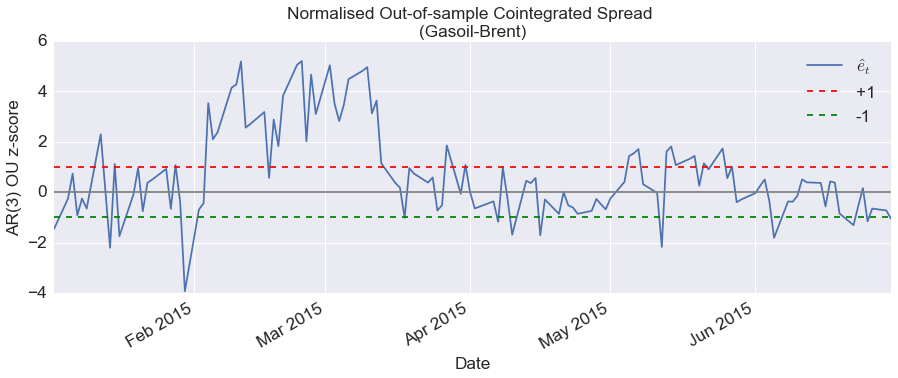

In [301]:
# ======== PLOT OUT-OF-SAMPLE Z-SCORE ========

# Normalise to OU bounds
normalised_e_t_hat_os = static_zscore(e_t_hat_os, mean=sm_mu_e, sigma=sm_sigma_e)
normalised_e_t_hat_os.plot()
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['$\hat{e}_t$', '+1', '-1'], loc='upper right')
plt.axhline(0, color='grey')
plt.ylabel('AR(3) OU z-score')
plt.title('Normalised Out-of-sample Cointegrated Spread \n(Gasoil-Brent)')

The corresponding P&L using the AR(3) bounds is shown below for both the in-sample and out-of-sample periods. A positive performance is observed throughout, although with prolonged drawdown periods. In addition, note this doesn't include **transaction costs** which could certainly add up to an overall loss. The P&L using the AR(1) bounds is also shown, where it is clear it is worse off than AR(3). Both however are better off than having simply gone long in gasoil or brent - this is taken as the market 'benchmark'.

Given the positive results, it would be interesting to see the P&L from extending to more than 2 assets cointegrated with oil, with a strategy that  trades multiple cointegrated spreads at the same time, or a single spread composed of more factors. In this case, the **Johansen test** would need to be implemented instead of CADF.

In [307]:
# ======= P&L USING AR(1) BOUNDS INSTEAD OF AR(3) BOUNDS =======
ar1_df_pnl_is = get_pnl_df(e_t_hat, mean=my_mu_e, sigma=my_sigma_e)
ar1_df_pnl_os = get_pnl_df(e_t_hat_os, mean=my_mu_e, sigma=my_sigma_e)

In [232]:
%run my_pyfolio.py  # needed to run functions below

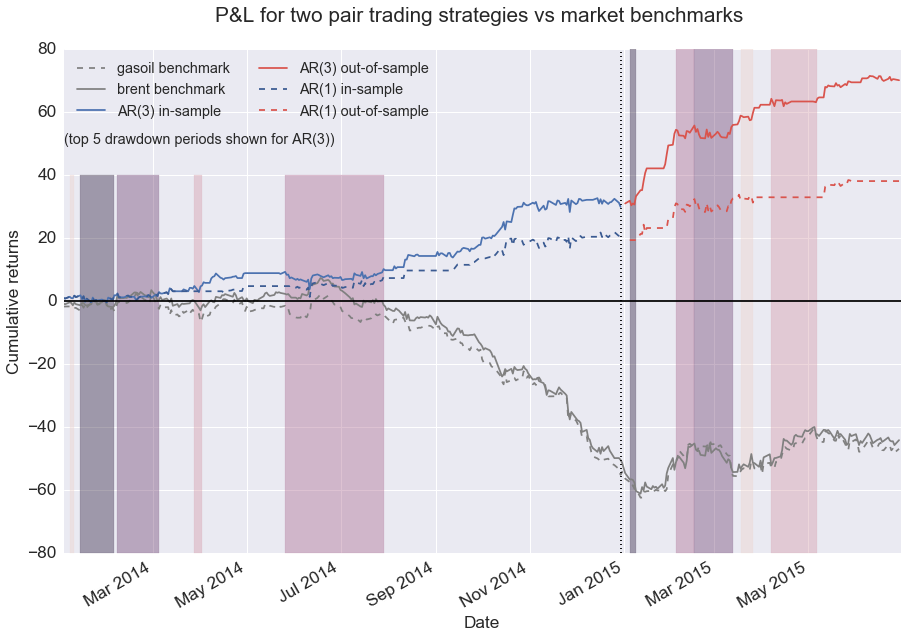

In [353]:
# ====== PLOT THE P&L CURVE FOR IN-SAMPLE AND OUT-OF-SAMPLE ======

plt.figure(1, figsize=(15, 10))

# Plot market benchmarks (going long on the asset)
df['gasoil'].diff().shift(-1).cumsum().plot(color='grey', linestyle='--')
df['brent'].diff().shift(-1).cumsum().plot(color='grey', linestyle='-')

# Plot in-sample and out-of-sample pnl for AR(3) bounds
k = df_pnl_is[:-1]['pnl_cum'][-1]  # last non-nan row of in-sample pnl
plot_drawdown_periods(df_pnl_is['pnl'], top=5)
plot_drawdown_periods(df_pnl_os['pnl'], k=k, top=5, color=sns.xkcd_rgb["pale red"])

# Plot pnl using AR(1) bounds
ar1_df_pnl_is['pnl_cum'].plot(color=sns.xkcd_rgb['denim blue'], linestyle='--')
(ar1_df_pnl_os['pnl_cum'] + ar1_df_pnl_is[:-1]['pnl_cum'][-1]).plot(color=sns.xkcd_rgb["pale red"], linestyle='--')

# Legends and line markers
plt.legend(['gasoil benchmark', 'brent benchmark', 
            'AR(3) in-sample', 'AR(3) out-of-sample',
           'AR(1) in-sample', 'AR(1) out-of-sample'], 
           loc='upper left', fontsize='large', ncol=2)
plt.axvline(df_temp.index[-1], color='black', linestyle=':')
plt.axhline(0, color='black', linestyle='-')
plt.title('P&L for two pair trading strategies vs market benchmarks \n', fontsize='xx-large')
plt.text(x=df_pnl_is['pnl'].index[0], y=50, s='(top 5 drawdown periods shown for AR(3))', size='large')

### Bounds from Optimisation

Although earlier the Gasoil-Brent spread passed the Anderson-Darling test for normality, we also saw it had memory AR(3). Hence, it is perhaps not optimal to use an OU fit to define the bounds, as this is only suited for an AR(1) spread. The P&L plot also suggests the performance is sensitive to where bounds are. This motivates the search for the _optimal bound_, which maximises the P&L or any other P&L-related metric, e.g. number of trades. Optimisation techniques can be used to test different combinations of $\mu_e \pm \sigma_{eq}$ in the in-sample data, although again, this can suffer from model overfitting and cause a worse performance in the out-of-sample. Due to time constrains this was not evaluated in this report.

### Dynamic Bounds

Another alternative is to use rolling values for $\mu_e \pm \sigma_{eq}$ instead of static. Again, an optimisation could be done to optimise the optimal period for the rolling window, which could be different for $\mu_e$ and $\sigma_{eq}$ given their different sensitivity to time-scales.

# APPENDIX

# Multivariate Regression 

Also known as 'generalised linear model', it generalises linear regression to multiple input variables (regressors) and $n$ observations. It  is best expressed in matrix form as:

$$
Y = X \beta + \epsilon
$$

where $Y$ is a vector representing the endogenous (dependent) variable, $X$ is a matrix representing the exogenous (independent) variables, $\beta$ is the coefficients vector and $\epsilon$ the residuals vector. 

The OLS method, which minimizes the sum of squared residuals via the Maximum Likelihood Estimation method (MLE), is used to estimate the parameters:

$$
\begin{align}
\hat{\beta} = (X^\prime X)^{-1} X^\prime Y \\
\hat{\epsilon} = Y - X \hat{\beta}
\end{align}
$$

The covariance matrix of the residuals estimate is:

$$
\hat{\Sigma} = scale \times  \sum \epsilon \epsilon^\prime
$$
where $scale = 1/ n$ using the MLE estimator or $scale= 1/ (n - kp)$ using the OLS estimator for a model with $k$ variables and $p$ lags.

The covariance matrix for the coefficients is:

$$
(X X^\prime)^{-1} \otimes \hat{\Sigma}
$$
where $\otimes$ is the _Kronecker product_. 

The Log Likelihood Function for OLS is:

$$
\log(L) = -\frac{n}{2}\log (2 \pi) -\frac{n}{2}\log | \hat{\Sigma}| - \frac{n}{2}
$$

The variance of the residuals and parameters are therefore the diagonal elements of the corresponding covariance matrices, from which the standard errors can be calculated. 

These are the conventions used in the script _analysis.py_. Additional mathematical details can be found in [wiki VAR](https://en.wikipedia.org/wiki/Vector_autoregression).

The are several assumptions about the nature of the variables  in the model to hold. In particular, these should be _stationary_ and the $\epsilon$ homoscedastic (with finite variance) and normally distributed.

The main applications of the multivariate regression are:
* Vector Autoregression Models - also known as VAR(p), these can be used to forecast, test for stationarity (e.g. ADF test) or model stationary series like returns
* Error Correction Model - also known as ECM, these are used to model series which aren't stationary or that have stochastic trends, like prices

## Autoregression Models - AR(p)

Also referred to as VAR(p) where _p_ is the lag order, the is simply a linear regression on a time series and its lagged (past) values:

$$
\begin{align}
Y_t = c + \sum^{p}_{i=1} \phi_i Y_{t-i} + \epsilon_t \\
\end{align}
$$

where c is a constant (also known as the drift term), $\phi_i$ are the parameters of the model and $\epsilon_t$ is the error term. Whether to exclude the constant $c$ or not depends on the nature of what we are trying to model.

Computationally, the model can be fitted in one go by using the OLS method described above with a special matrix formulation. Example code for this can be found in _analysis.py_ in the project repository.

As shown in Section X, the VAR(p) system can be rewritten in terms of differences and lagged differeces, which is how it is commonly expressed in some cases, for example in the ADF test. See more details in [wiki VAR](https://en.wikipedia.org/wiki/Vector_autoregression), [wiki AR](https://en.wikipedia.org/wiki/Autoregressive_model)


### Dickey-Fuller Test and ADF

The _Dickey-Fuller test_ tests the null hypothesis of whether a unit root is present in the autoregressive model (also known as AR(p), see Appendix) of the time series. For example, a simple AR(1) model is:

$$
Y_t = \beta Y_{t-1} + \epsilon_t
$$

If $\beta=1$ the series is said to have a 'unit root' and is hence non-stationary. The equation can be rewriten as:

$$
\Delta Y_t = (\beta - 1) Y_{t-1} + \epsilon_t = \phi Y_{t-1} + \epsilon_t
$$

where $\phi= \beta-1$. Hence, testing for unit root is equivalent to testing $\phi=0$. 

The value of the test statistic $\hat{\phi}/std.err(\hat{\phi})$ is then compared to the relevant critical values for the Dickey-Fuller distribution. If found lower, then the null hypothesis $\phi=0$ is rejected and the series can be considered stationary.

There are 3 main versions of the test depending on whether drift and/or time-dependent terms are included:

* Test for a unit root: $\Delta Y_t = \phi Y_{t-1} + \epsilon_t$
* Test for a unit root with drift: $\Delta Y_t = c_0 + \phi Y_{t-1} + \epsilon_t$
* Test for a unit root with drift and deterministic time trend: $\Delta Y_t = c_0 + c_1 t + \phi Y_{t-1} + \epsilon_t$

Each version of the test has its own critical values which depends on the size of the sample. Which version to use isn't straightforward and the wrong choice can lead to wrong conclusions. In general, financial time series exclude the time trend.

There is an extension to the test called the **Augmented Dickey–Fuller test (ADF)**, which removes autocorrelation effects by including lagged difference terms $\phi_p \Delta Y_{t-p}$.  The optimal lag oder could then be determined from the information criteria (see above). 

Clearly the above equations belong to the family of generalised linear models, which means the parameters can be estimated using the familiar linear regression  described above.

Additional details on this topic can be found in [wiki ADF](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test), [wiki DF](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) and the Appendix.

### Optimal Lag Order

To select the optimal lag order, one approach uses the Akaike Information Criterion (AIC). Iterating over different lag orders, the one yielding the lowest value of AIC is selected. Statsmodels suggest to try up to a maximum lag order of $12*(n/100)^{1/4}$ where $n$ is the number of observations.

There are different definitions of AIC used - we use the same as in  [statstools](http://statsmodels.sourceforge.net/stable/vector_ar.html#lag-order-selection), which has different definitions  for AR(p) and ADF test as:

$$
\begin{equation}
AIC = \log | \hat{\Sigma} |+ 2 \frac{1 + k}{n} \qquad \mathrm{(AR(p) \ model)} \\
AIC = -2 \log(L) + 2k  \qquad \mathrm{(ADF \ test)} 
\end{equation}
$$

where $k$ is the number of estimated parameters. Other information criteria can be used, see for example [ref](https://en.wikipedia.org/wiki/Information_criterion).


### Stability Condition

It requires for the eigenvalues of the estimated coefficients matrix or vector to be
inside the unit circle ($ < 1$):
$$
| \lambda I - \hat{\beta} | = 0
$$
This is equivalent to requiring the roots of the characteristic polynomial of the AR(p) system to be outside the unit circle - see [ref](http://matthieustigler.github.io/Lectures/Lect2ARMA.pdf).

# Cointegration between Italian and Dutch Gas

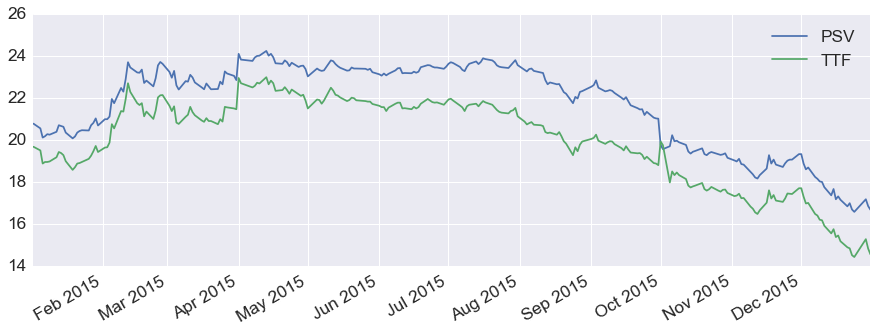

In [233]:
df_gas = pd.read_excel("data/PSV_TTF.xlsx", sheetname="Sheet1", index_col=0, dayfirst=True)
df_gas.columns = ["PSV", "TTF"]
df_gas = df_gas.dropna()  # remove missing values
df_gas_is = df_gas[datetime(2015, 1, 1): datetime(2015, 12, 31)] 
df_gas_is.plot()

In [12]:
# ======  ENGLE-GRANGER 2-STEP METHOD  ======

# ===== STEP 1: GET SPREAD FROM OLS =====

# My OLS and ADF implementatin
from analysis import my_OLS

# Import statsmodels equivalents to validate results
from statsmodels.tsa.tsatools import add_constant
from statsmodels.regression.linear_model import OLS

# Define variables
x = df_gas_is['TTF']  # explanatory variable ('X')
y = df_gas_is['PSV']   # dependent variable ('Y')
# x = df_is['brent'].diff().dropna()  # explanatory variable ('X')
# y = df_is['gasoil'].diff().dropna()   # dependent variable ('Y')

# Do OLS
x = add_constant(x)
my_res_ols = my_OLS(y, x)
sm_res_ols = OLS(y, x).fit()  # validate result with statsmodels
x = x.iloc[:, 1]  # remove the constant now that we're done

# Set values of estimated parameters
c_hat = my_res_ols['params'][0]
beta2_hat = my_res_ols['params'][1]
# cointegration spread, should be == sm_res_ols.resid ==  my_res_ols['resid_hat']
e_t_hat = y - c_hat - beta2_hat*x
e_t_hat.name = 'e_t_hat'

# print my_res_ols['params']
# print sm_res_ols.params
# print e_t_hat.mean()
sm_res_ols.summary2()
# print my_res_ols['resid_hat'].head()
# print sm_res_ols.resid.head()
# print e_t_hat.head()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.960    
Dependent Variable: PSV              AIC:                270.4483 
Date:               2016-07-22 10:10 BIC:                277.5151 
No. Observations:   253              Log-Likelihood:     -133.22  
Df Model:           1                F-statistic:        5995.    
Df Residuals:       251              Prob (F-statistic): 3.35e-177
R-squared:          0.960            Scale:              0.16918  
---------------------------------------------------------------------
          Coef.     Std.Err.       t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const     2.4463      0.2501     9.7813    0.0000    1.9538    2.9389
TTF       0.9635      0.0124    77.4246    0.0000    0.9390    0.9880
------------------------------------------------------------------
Omnibus:               20.913       Durbin-Watson:          0.239 
Prob(Omnibus):         0.000        Jarque-Bera (JB):       73.449
Skew:                  -0.129       Prob(JB):               0.000 
Kurtosis:              5.627        Condition No.:          195   
==================================================================

"""

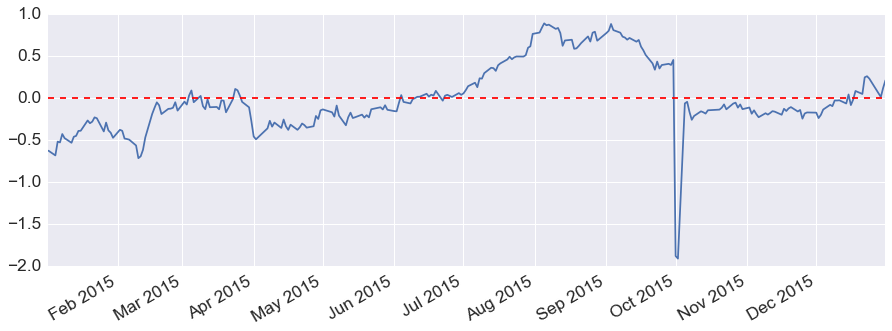

In [16]:
e_t_hat.plot()
plt.axhline(e_t_hat.mean(), color='red', linestyle='--') # Add the mean

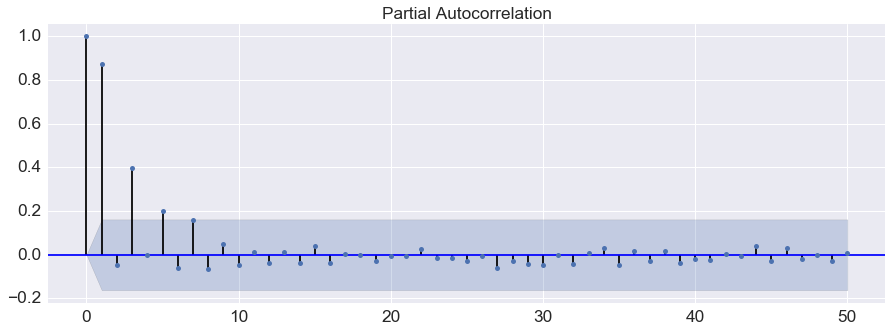

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf
_ = plot_pacf(e_t_hat, lags=50, alpha=0.01)